## Enviromental Data from water
This dataset cosists of 25 ponds from which samples were taken in 3 different timepoints, at beggining(one week into experiment), midpoint(1 month into experiment) and end(3 months into experiment) of the experiment. 
This notebook will focus on microbiome data collected from sediment of watertanks holding fish with different probiotic supplementation added. Explanation of ponds can be found later in the notebook.

### Import and preprocessing

In [17]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize , LabelEncoder
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from functions import *

np.random.seed(111)
tf.random.set_seed(111)

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/H2O_based/Data/H2O_KEGG_paths_merged.csv')
df.head()

timepoint pond   ID  ko05340    ko00564    ko00680   ko00562    ko03030  \
0          1   S8  126  6073.50   64366.77  108494.35  17731.16   80175.45   
1          2   S8  127  7796.58   89529.66  160055.28  25823.92  110647.68   
2          3   S8  128  7358.46   91213.27  158115.18  26196.54  109971.20   
3          1  S14  129  8701.42  121083.63  191045.82  30691.34  153576.79   
4          2  S14  130  4951.16   56734.02   93510.77  15153.31   71580.19   

    ko00561  ko00440  ...  ko04722  ko00513  ko03040  ko01056  ko00909  \
0  35559.13  5673.83  ...      0.0      0.0      0.0      0.0      0.0   
1  52317.48  7806.99  ...      0.0      0.0      0.0      0.0      0.0   
2  50663.96  7552.93  ...      0.0      0.0      0.0      0.0      0.0   
3  67642.94  7514.92  ...      0.0      0.0     25.0      0.0      0.0   
4  31677.26  3515.99  ...      0.0      0.0      0.0      4.0      0.0   

   ko00514  ko00533  ko00601  ko05414  ko04380  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0  

[5 rows x 238 columns]

In [20]:
predictors = df.columns[3:]
print("number of predictors: ", len(predictors))
df['timepoint'] = LabelEncoder().fit_transform(df['timepoint'])

df.shape

number of predictors:  235


(73, 238)

In [21]:
df[df['pond'] == "S29"]

timepoint pond   ID  ko05340   ko00564    ko00680   ko00562   ko03030  \
11          1  S29  139  6679.99  65295.37  113596.69  19715.97  77881.74   
12          2  S29  140  6027.67  58051.33   98132.31  16834.69  70012.32   

     ko00561  ko00440  ...  ko04722  ko00513  ko03040  ko01056  ko00909  \
11  38951.27  4971.48  ...      0.0      0.0      0.0      0.0     3.33   
12  35047.92  5745.51  ...      0.0      0.0      0.0     20.0     4.00   

    ko00514  ko00533  ko00601  ko05414  ko04380  
11      0.0      0.0      0.0      0.0      0.0  
12      0.0      0.0      0.0      0.0      0.0  

[2 rows x 238 columns]

In [22]:
df[df['pond'] == "S18"]

timepoint pond   ID  ko05340   ko00564   ko00680   ko00562   ko03030  \
6          1  S18  133  4325.26  45389.25  79433.21  14583.68  52588.07   
7          2  S18  134  2905.60  28366.91  54303.43   9346.12  37458.39   

    ko00561  ko00440  ...  ko04722  ko00513  ko03040  ko01056  ko00909  \
6  27815.74  3437.25  ...      0.0      0.0      0.0      0.0      0.0   
7  20127.17  3179.27  ...      0.0      0.0      0.0      0.0      0.0   

   ko00514  ko00533  ko00601  ko05414  ko04380  
6      0.0      0.0      0.0      0.0      0.0  
7      0.0      0.0      0.0      0.0      0.0  

[2 rows x 238 columns]

We see that our dataset consists 186 different bacteria famillies which we will use as predictors for later analysis. We can also note that we have two missing samples from timepoint 0 ponds 29 and 18. 

Text(0.5, 0, 'Predictors')

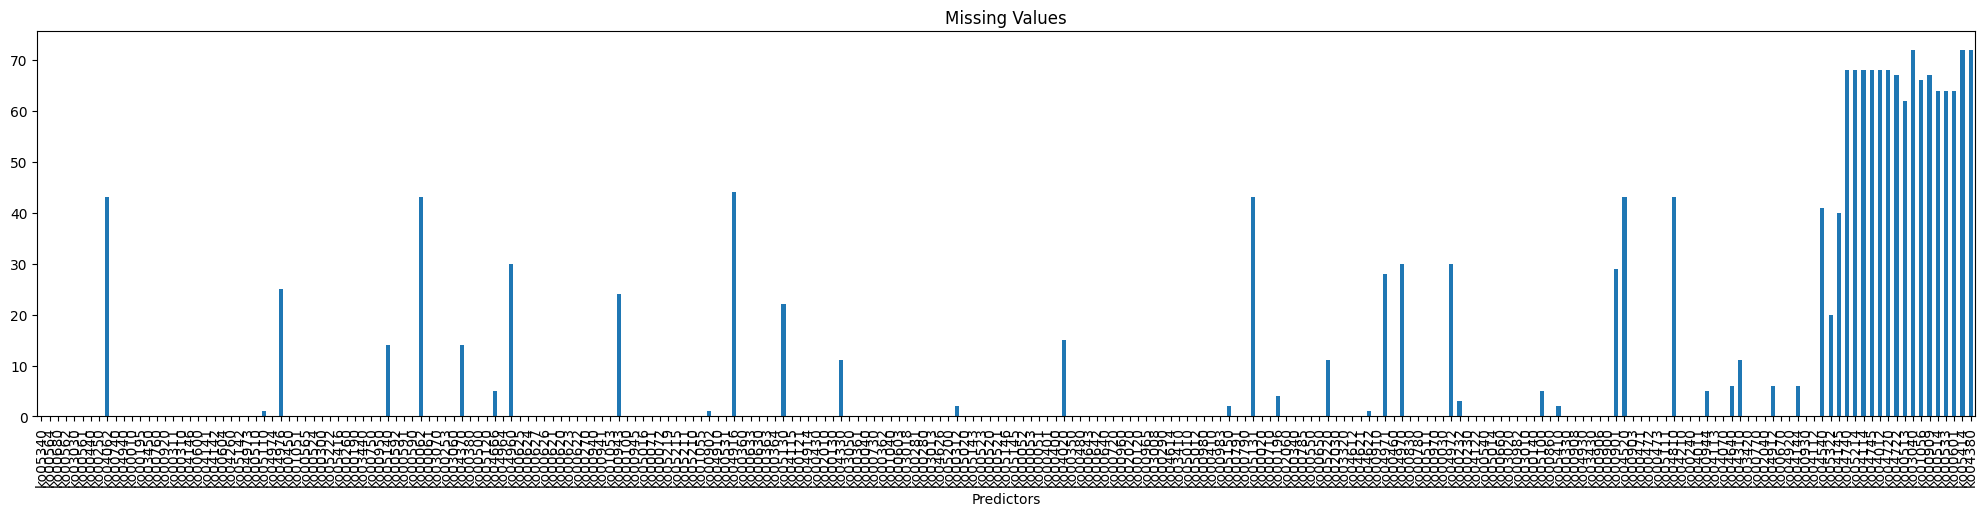

In [23]:
missing_or_zero = df[predictors].isna().sum() + (df[predictors] == 0).sum()

missing_or_zero.plot(kind='bar', figsize=(25, 5))
plt.title('Missing Values')
plt.xlabel('Predictors')

The distribution of missing values is quite similar to other datasets, we will once again fill missing values with 0 as it makes most biological sense.

In [24]:
df.fillna(0, inplace=True)

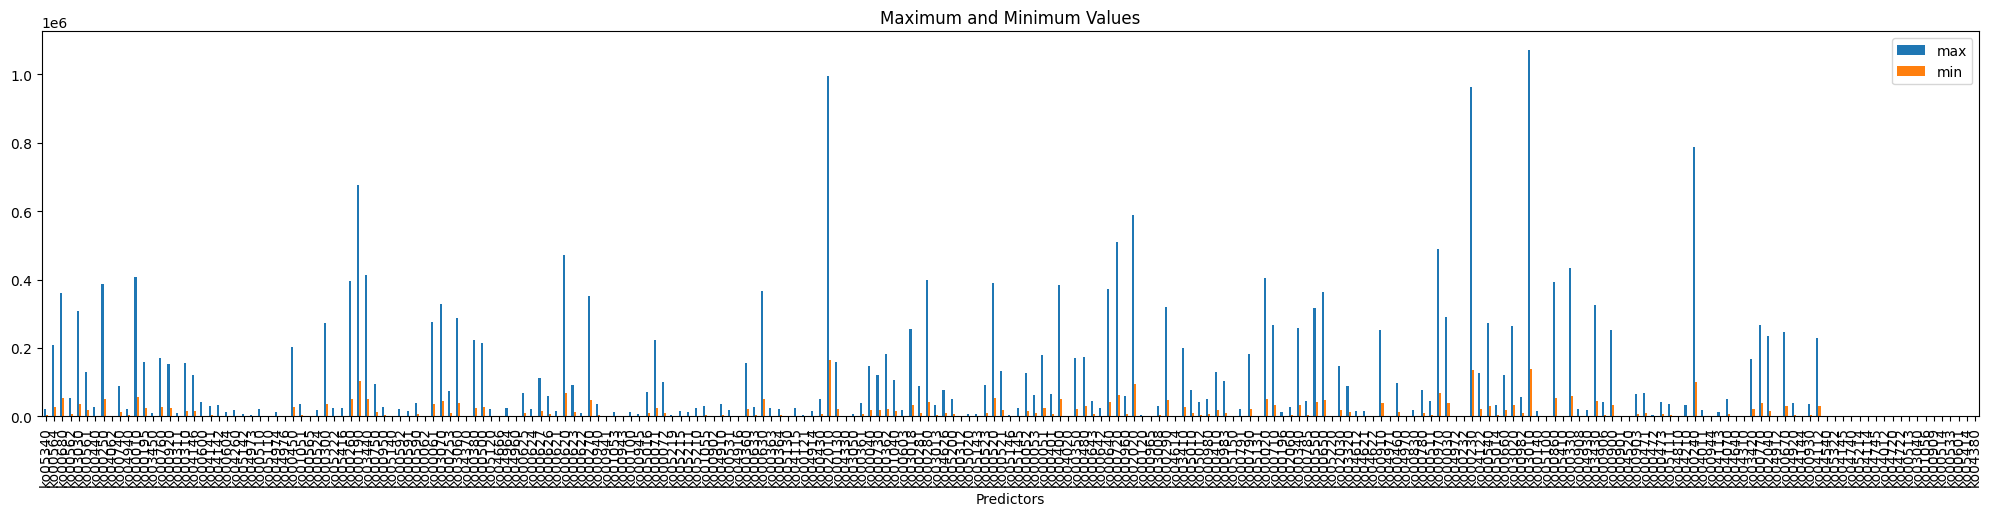

In [25]:
max_values = df[predictors].max()
min_values = df[predictors].min()


max_min_df = pd.DataFrame({'max': max_values, 'min': min_values})
max_min_df.plot(kind='bar', figsize=(25, 5))
plt.title('Maximum and Minimum Values')
plt.xlabel('Predictors')
plt.show()

Distribution of maximum and minimum values for each predictor also varies a lot so we will normalise them by column using standard min max scaling.

In [26]:
df[predictors] = normalize(df[predictors],norm = 'max', axis=0)

In [27]:
df.describe()

timepoint          ID    ko05340    ko00564    ko00680    ko00562  \
count  73.000000   73.000000  73.000000  73.000000  73.000000  73.000000   
mean    1.027397  163.767123   0.363899   0.434387   0.419498   0.469480   
std     0.816030   21.577072   0.174301   0.196437   0.183884   0.195661   
min     0.000000  126.000000   0.128312   0.135332   0.150805   0.161484   
25%     0.000000  146.000000   0.254426   0.293958   0.290637   0.318804   
50%     1.000000  164.000000   0.319273   0.417272   0.403324   0.456837   
75%     2.000000  182.000000   0.453965   0.559739   0.535379   0.579749   
max     2.000000  200.000000   1.000000   1.000000   1.000000   1.000000   

         ko03030    ko00561    ko00440    ko00250  ...    ko04722    ko00513  \
count  73.000000  73.000000  73.000000  73.000000  ...  73.000000  73.000000   
mean    0.368518   0.419055   0.303913   0.383666  ...   0.038052   0.033268   
std     0.180389   0.192217   0.173138   0.179261  ...   0.148402   0.141287   
min     0.121338   0.145402   0.088273   0.131285  ...   0.000000   0.000000   
25%     0.241423   0.274568   0.193062   0.255106  ...   0.000000   0.000000   
50%     0.351229   0.403966   0.242219   0.359235  ...   0.000000   0.000000   
75%     0.452279   0.516891   0.376955   0.498088  ...   0.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   

         ko03040   ko01056    ko00909    ko00514    ko00533    ko00601  \
count  73.000000  73.00000  73.000000  73.000000  73.000000  73.000000   
mean    0.013699   0.03070   0.028919   0.031620   0.031620   0.031620   
std     0.117041   0.13028   0.128523   0.141265   0.141265   0.141265   
min     0.000000   0.00000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.00000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.00000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.00000   0.000000   0.000000   0.000000   0.000000   
max     1.000000   1.00000   1.000000   1.000000   1.000000   1.000000   

         ko05414    ko04380  
count  73.000000  73.000000  
mean    0.013699   0.013699  
std     0.117041   0.117041  
min     0.000000   0.000000  
25%     0.000000   0.000000  
50%     0.000000   0.000000  
75%     0.000000   0.000000  
max     1.000000   1.000000  

[8 rows x 237 columns]

Next we will decode our pond column to obtain classes

Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [28]:
def pond_decoder(x,codes):
   
    x=x.replace('S','')
    num = int(x)
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


C:\Users\marek\AppData\Local\Temp\ipykernel_8932\3647536681.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [29]:
df = df.copy()

In [30]:
df.head()

timepoint pond   ID   ko05340   ko00564   ko00680   ko00562   ko03030  \
0          0   S8  126  0.268208  0.307079  0.301297  0.334936  0.259710   
1          1   S8  127  0.344300  0.427125  0.444486  0.487805  0.358417   
2          2   S8  128  0.324952  0.435158  0.439098  0.494844  0.356226   
3          0  S14  129  0.384258  0.577662  0.530549  0.579749  0.497476   
4          1  S14  130  0.218645  0.270665  0.259687  0.286241  0.231867   

    ko00561   ko00440  ...  ko00513  ko03040   ko01056  ko00909  ko00514  \
0  0.274568  0.205962  ...      0.0      0.0  0.000000      0.0      0.0   
1  0.403966  0.283396  ...      0.0      0.0  0.000000      0.0      0.0   
2  0.391199  0.274173  ...      0.0      0.0  0.000000      0.0      0.0   
3  0.522301  0.272794  ...      0.0      1.0  0.000000      0.0      0.0   
4  0.244594  0.127631  ...      0.0      0.0  0.044444      0.0      0.0   

   ko00533  ko00601  ko05414  ko04380  class_pond  
0      0.0      0.0      0.0      0.0           0  
1      0.0      0.0      0.0      0.0           0  
2      0.0      0.0      0.0      0.0           0  
3      0.0      0.0      0.0      0.0           0  
4      0.0      0.0      0.0      0.0           0  

[5 rows x 239 columns]

With now dataset ready for analysis we will try to build, train and evaluate models 

### Modeling timepoints only

#### Model building


In [31]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=111, stratify=df['timepoint'])

In [32]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
#model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dense(3, activation ='softmax'))
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6667 - loss: 0.9672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
predicted classes:       [0 1 2 1 1 1 1 2 2 1 0 2]
true validation classes: [0 1 2 1 1 1 2 1 1 1 2 2]
mean confidence score: 6289.4868, sd confidence score: 20145.4212
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7500 - loss: 0.6285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted classes:       [2 0 1 2 2 2 0 1 1 0 0 0]
true validation classes: [2 0 1 2 2 1 0 0 2 0 0 0]
mean confidence score: 67775.8052, sd confidence score: 152055.4657
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5833 - loss: 0.8474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted classes:       [1 0 2 2 0 1 1 2 0 0 1 1]
true validation classes: [1 1 2 2 1 1 2 1 0 0 1 2]
mean confidence score: 367.4677, sd confidence score: 721.0939
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6364 -

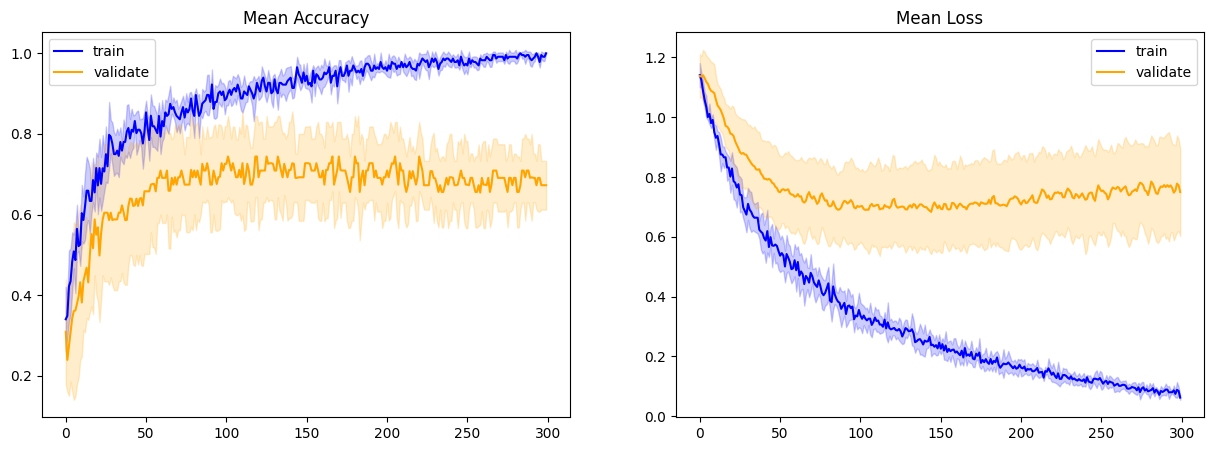

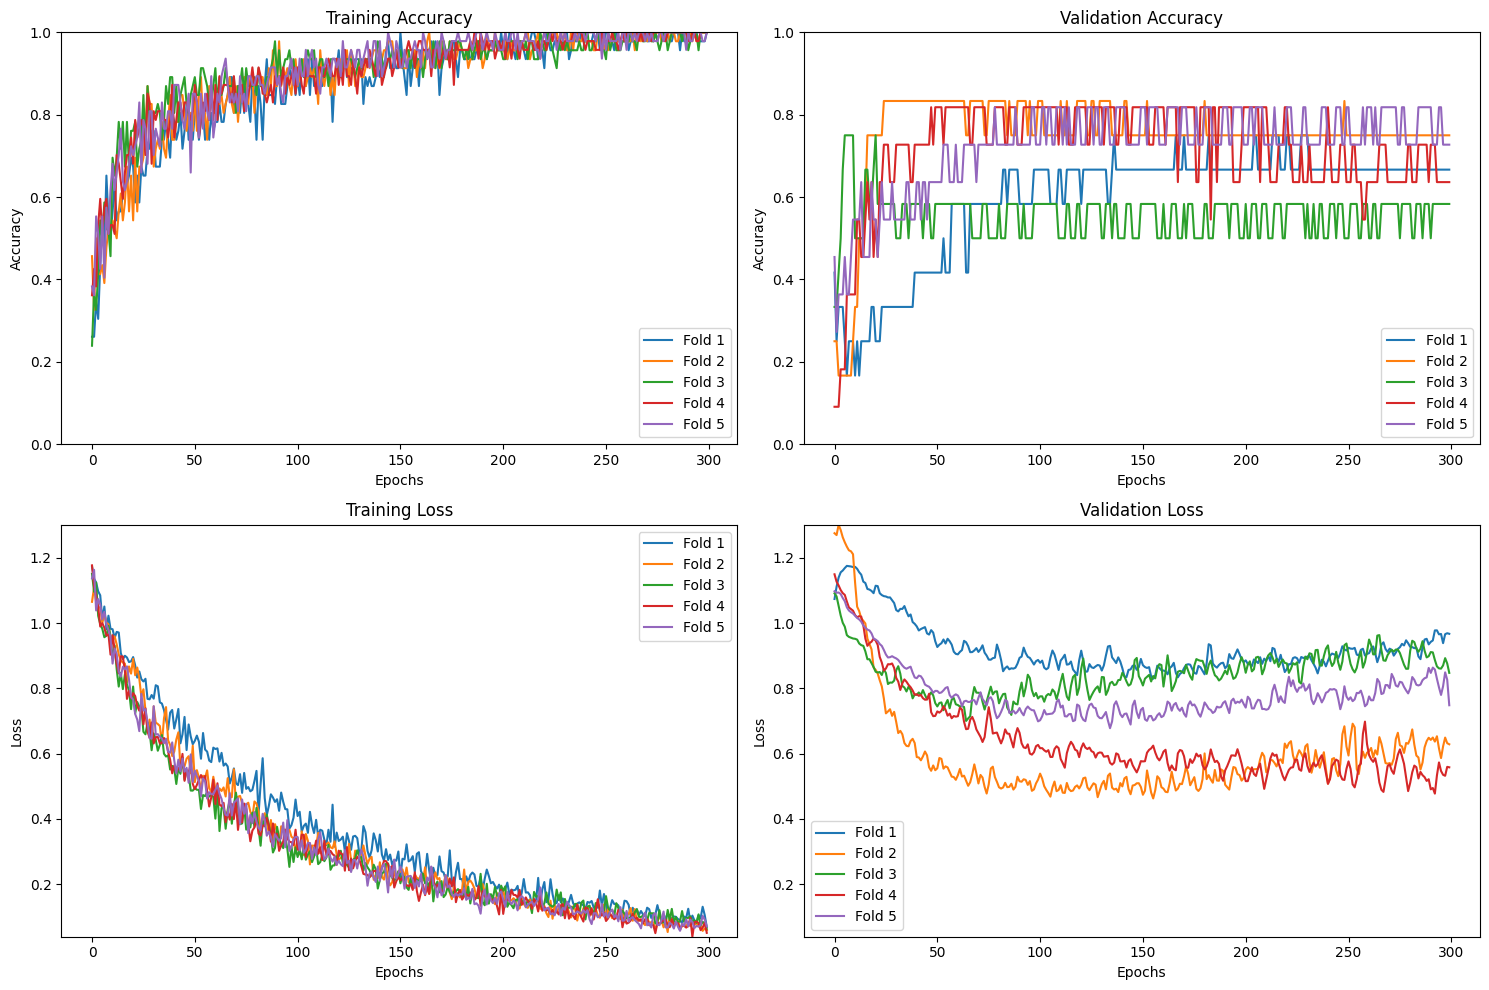

In [33]:
crossvalidate(train_val_df, model1, predictors, "timepoint", kf)

In [35]:
reset_weights(model1)
history = model1.fit(train_val_df[predictors], keras.utils.to_categorical(train_val_df['timepoint']),validation_split=0.2, epochs= 300, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=50)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8667 - loss: 0.5886
[0.5885866284370422, 0.8666666746139526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted values: [2 0 1 0 1 0 0 0 2 1 1 0 2 0 1]
True values: [2 0 1 2 1 2 0 0 2 1 1 0 2 0 1]


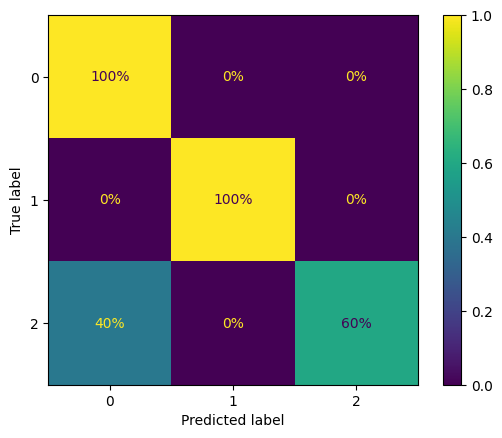

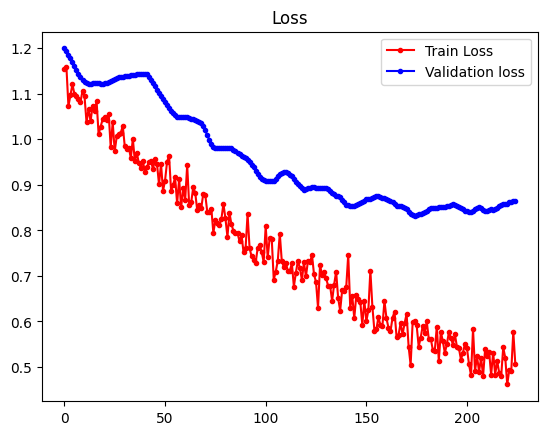

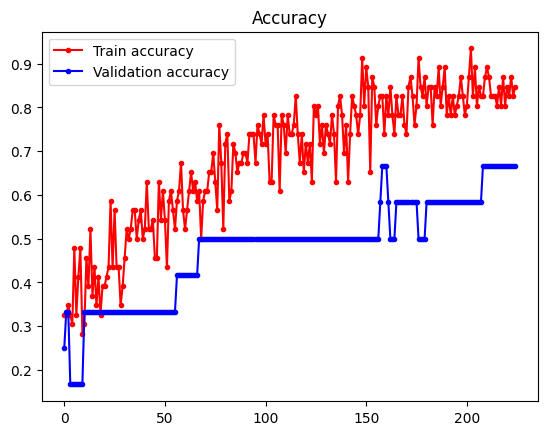

In [36]:
evaluate_model(model1,history,test_df[predictors], keras.utils.to_categorical(test_df['timepoint']))

As for previous approaches we can note that the differences between timepoints can be clearly defined by the model as its results for validation datasets are very good despite having now 3 timepoints, and testing on previously unseen by model test set.

We will now try to classify based only on different experimental setups. 

### Modeling differences between Classes for both timepoints at the same time

In [40]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1333 - loss: 5.2122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
predicted classes:       [2 4 0 0 0 2 4 1 4 0 4 1 4 2 4]
true validation classes: [0 1 1 1 1 1 2 2 2 3 3 3 4 4 4]
mean confidence score: 75.2447, sd confidence score: 123.0161
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1333 - loss: 5.2522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [0 2 2 4 2 0 3 2 2 2 2 2 2 2 2]
true validation classes: [0 0 0 1 1 2 3 3 3 3 3 4 4 4 4]
mean confidence score: 574.8021, sd confidence score: 1620.8215
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0667 - loss: 3.1505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
predicted classes:       [1 3 1 0 3 0 0 0 1 0 4 2 1 0 2]
true validation classes: [0 0 1 1 2 2 2 2 3 3 3 4 4 4 4]
mean confidence score: 13.9678, sd confidence score: 23.3128
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70m

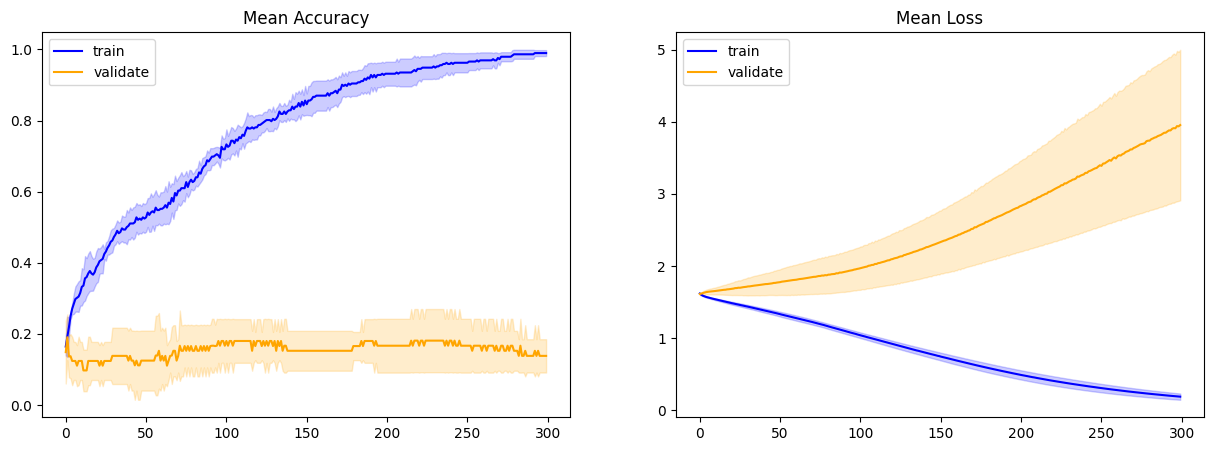

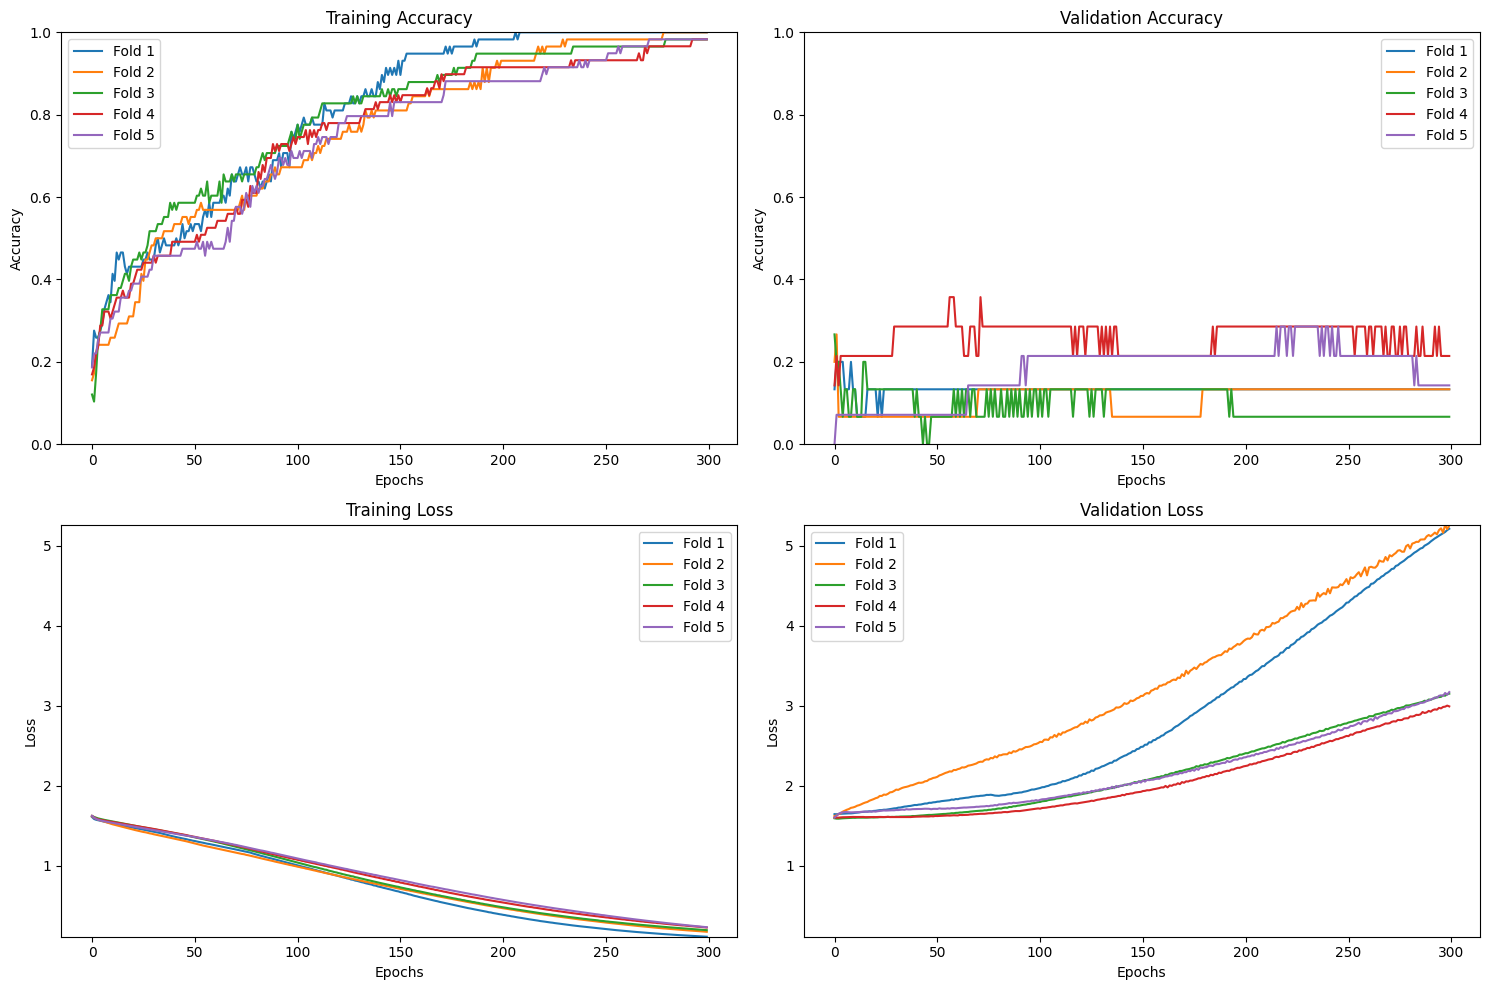

In [41]:
crossvalidate(df, model2, predictors, "class_pond", kf)

We can note similarly bad results as for different datasets, the reason for that is probably that we do not account for differences between timepoints, we will try to classify ponds in different timepoints now.


### Modeling class differences in first timepoint

In [42]:
df_first_tp = df[df["timepoint"]==0]
print(df_first_tp.shape)
df_first_tp.head()

(23, 239)


timepoint pond   ID   ko05340   ko00564   ko00680   ko00562   ko03030  \
0           0   S8  126  0.268208  0.307079  0.301297  0.334936  0.259710   
3           0  S14  129  0.384258  0.577662  0.530549  0.579749  0.497476   
8           0  S24  135  0.589717  0.722106  0.692880  0.721738  0.671094   
13          0  S12  141  0.151617  0.202990  0.185112  0.224261  0.171367   
16          0  S16  144  0.534369  0.612336  0.544459  0.634767  0.491745   

     ko00561   ko00440  ...  ko00513  ko03040  ko01056  ko00909  ko00514  \
0   0.274568  0.205962  ...      0.0      0.0      0.0      0.0      0.0   
3   0.522301  0.272794  ...      0.0      1.0      0.0      0.0      0.0   
8   0.710790  0.565973  ...      0.0      0.0      0.0      0.0      0.0   
13  0.199837  0.106118  ...      0.0      0.0      0.0      0.0      0.0   
16  0.620479  0.450592  ...      0.0      0.0      0.0      0.0      0.0   

    ko00533  ko00601  ko05414  ko04380  class_pond  
0       0.0      0.0      0.0      0.0           0  
3       0.0      0.0      0.0      0.0           0  
8       0.0      0.0      0.0      0.0           0  
13      0.0      0.0      0.0      0.0           1  
16      0.0      0.0      0.0      0.0           1  

[5 rows x 239 columns]

In [43]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.0000e+00 - loss: 2.3025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
predicted classes:       [2 2 3 2 0]
true validation classes: [1 1 2 3 3]
mean confidence score: 3.5349, sd confidence score: 4.1594
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2000 - loss: 2.1293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
predicted classes:       [2 4 3 3 2]
true validation classes: [0 1 1 3 3]
mean confidence score: 2.3791, sd confidence score: 3.2347
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2000 - loss: 2.4136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted classes:       [3 2 2 2 2]
true validation classes: [0 2 3 4 4]
mean confidence score: 3.4432, sd confidence score: 3.1656
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0000e+00 - loss: 3.7257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
predicted classes:       [3 2 1 4]
true v

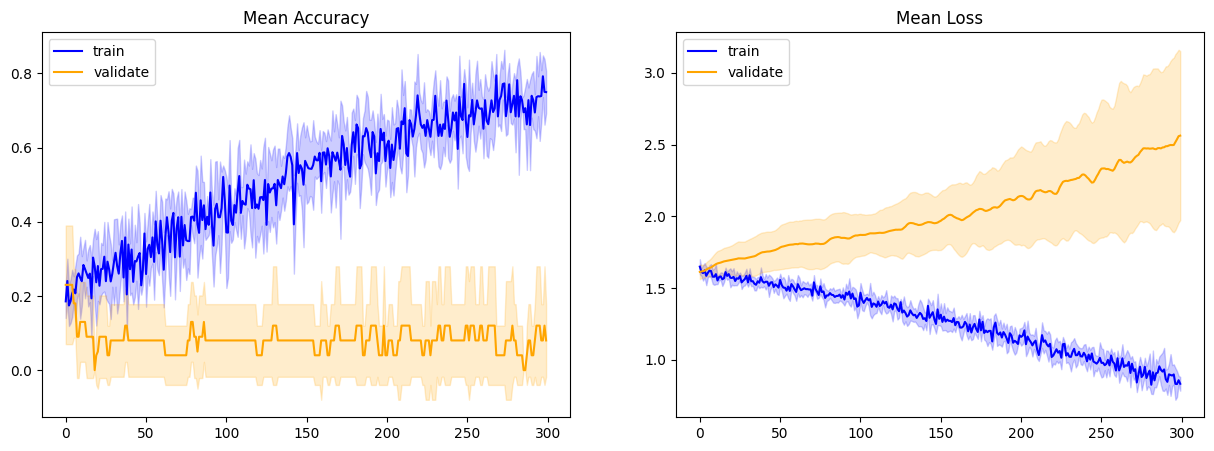

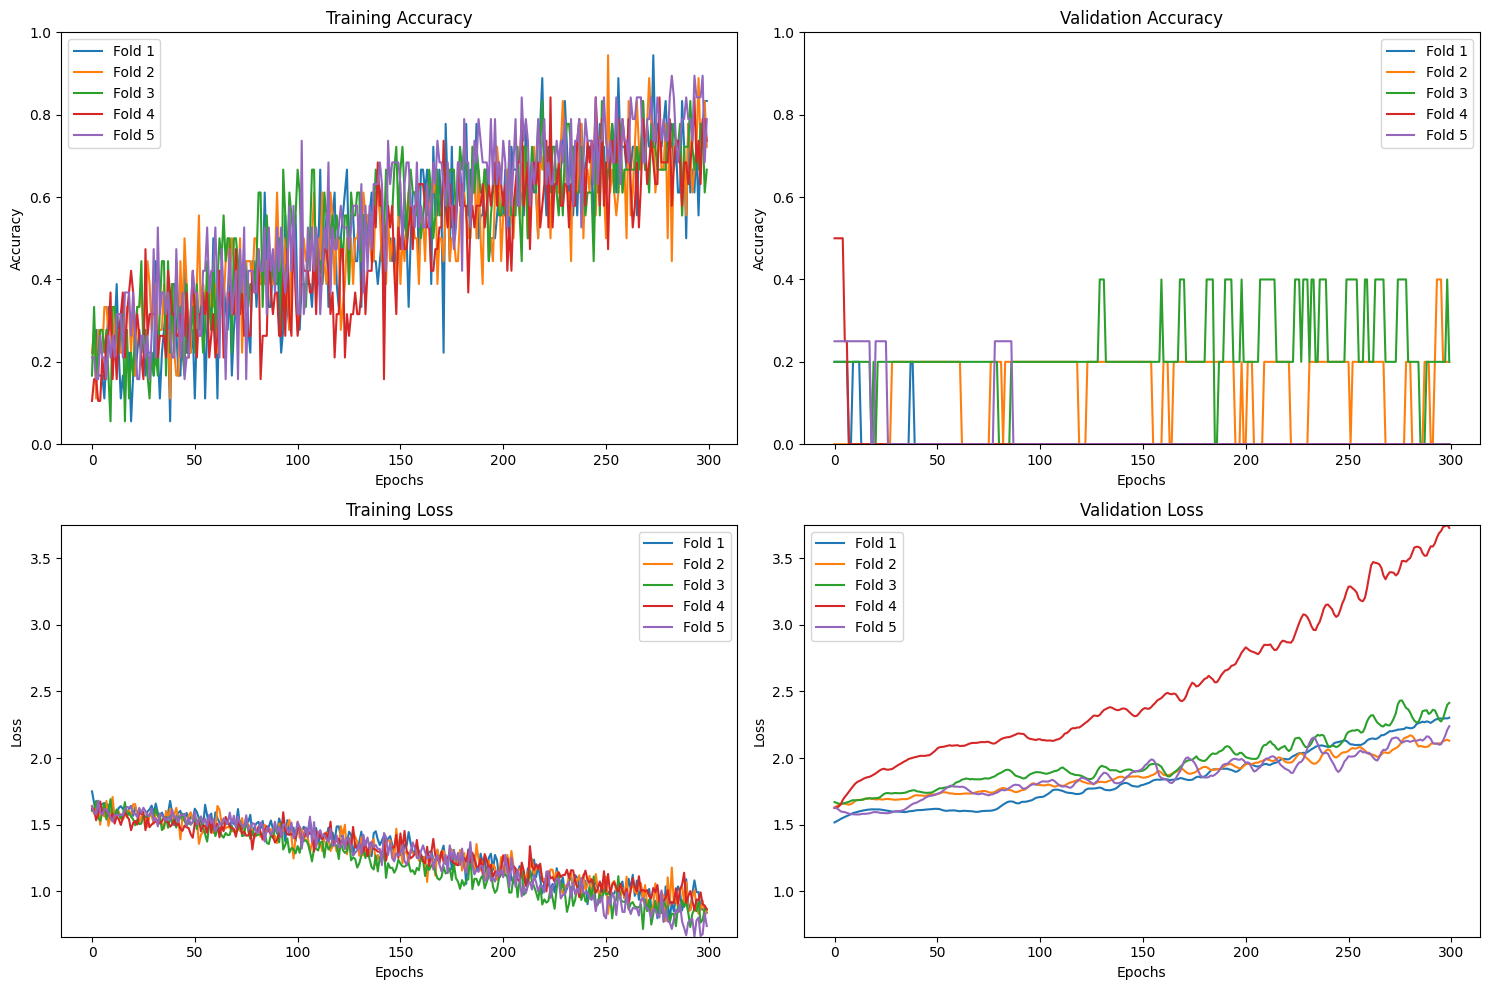

In [44]:
crossvalidate(df_first_tp, model3, predictors, "class_pond", kf)

### Modeling class differences in second timepoint

In [45]:
df_second_tp = df[df["timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 239)


timepoint pond   ID   ko05340   ko00564   ko00680   ko00562   ko03030  \
1           1   S8  127  0.344300  0.427125  0.444486  0.487805  0.358417   
4           1  S14  130  0.218645  0.270665  0.259687  0.286241  0.231867   
6           1  S18  133  0.191005  0.216542  0.220592  0.275481  0.170347   
9           1  S24  136  0.227496  0.301427  0.327496  0.303054  0.251034   
11          1  S29  139  0.294991  0.311509  0.315467  0.372428  0.252280   

     ko00561   ko00440  ...  ko00513  ko03040   ko01056  ko00909  ko00514  \
1   0.403966  0.283396  ...      0.0      0.0  0.000000    0.000      0.0   
4   0.244594  0.127631  ...      0.0      0.0  0.044444    0.000      0.0   
6   0.214778  0.124773  ...      0.0      0.0  0.000000    0.000      0.0   
9   0.272683  0.193062  ...      0.0      0.0  0.000000    0.000      0.0   
11  0.300760  0.180466  ...      0.0      0.0  0.000000    0.185      0.0   

    ko00533  ko00601  ko05414  ko04380  class_pond  
1       0.0      0.0      0.0      0.0           0  
4       0.0      0.0      0.0      0.0           0  
6       0.0      0.0      0.0      0.0           0  
9       0.0      0.0      0.0      0.0           0  
11      0.0      0.0      0.0      0.0           0  

[5 rows x 239 columns]

In [46]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.0000e+00 - loss: 2.0585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
predicted classes:       [4 1 4 4 1]
true validation classes: [0 0 2 2 3]
mean confidence score: 5.6352, sd confidence score: 3.3845
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 2.2123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [4 0 3 0 2]
true validation classes: [1 1 2 3 3]
mean confidence score: 2.3014, sd confidence score: 2.7474
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2000 - loss: 1.8852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted classes:       [4 4 4 2 4]
true validation classes: [0 0 2 3 4]
mean confidence score: 2.2761, sd confidence score: 1.0574
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2000 - loss: 2.2020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted classes:       [0 3 3 4 3]
true v

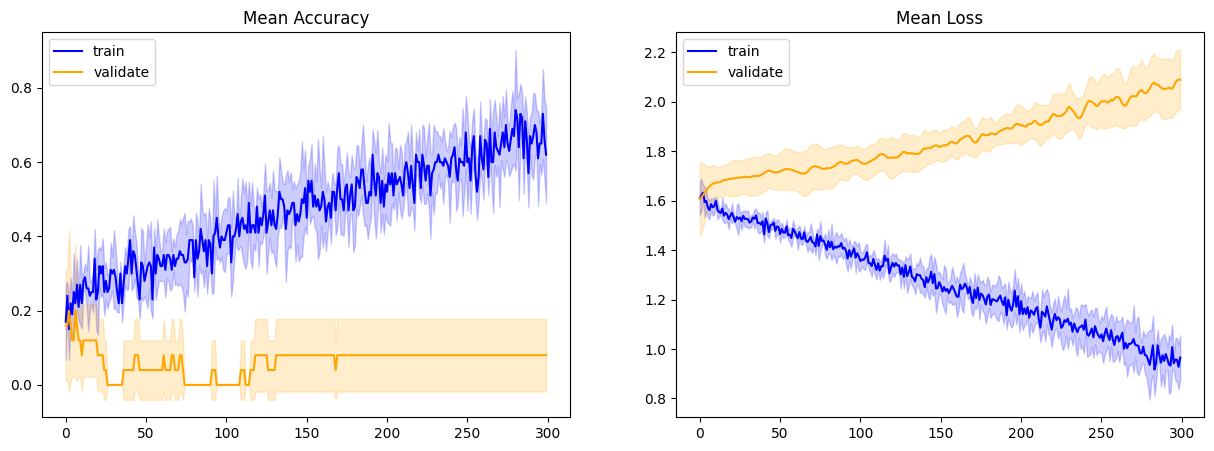

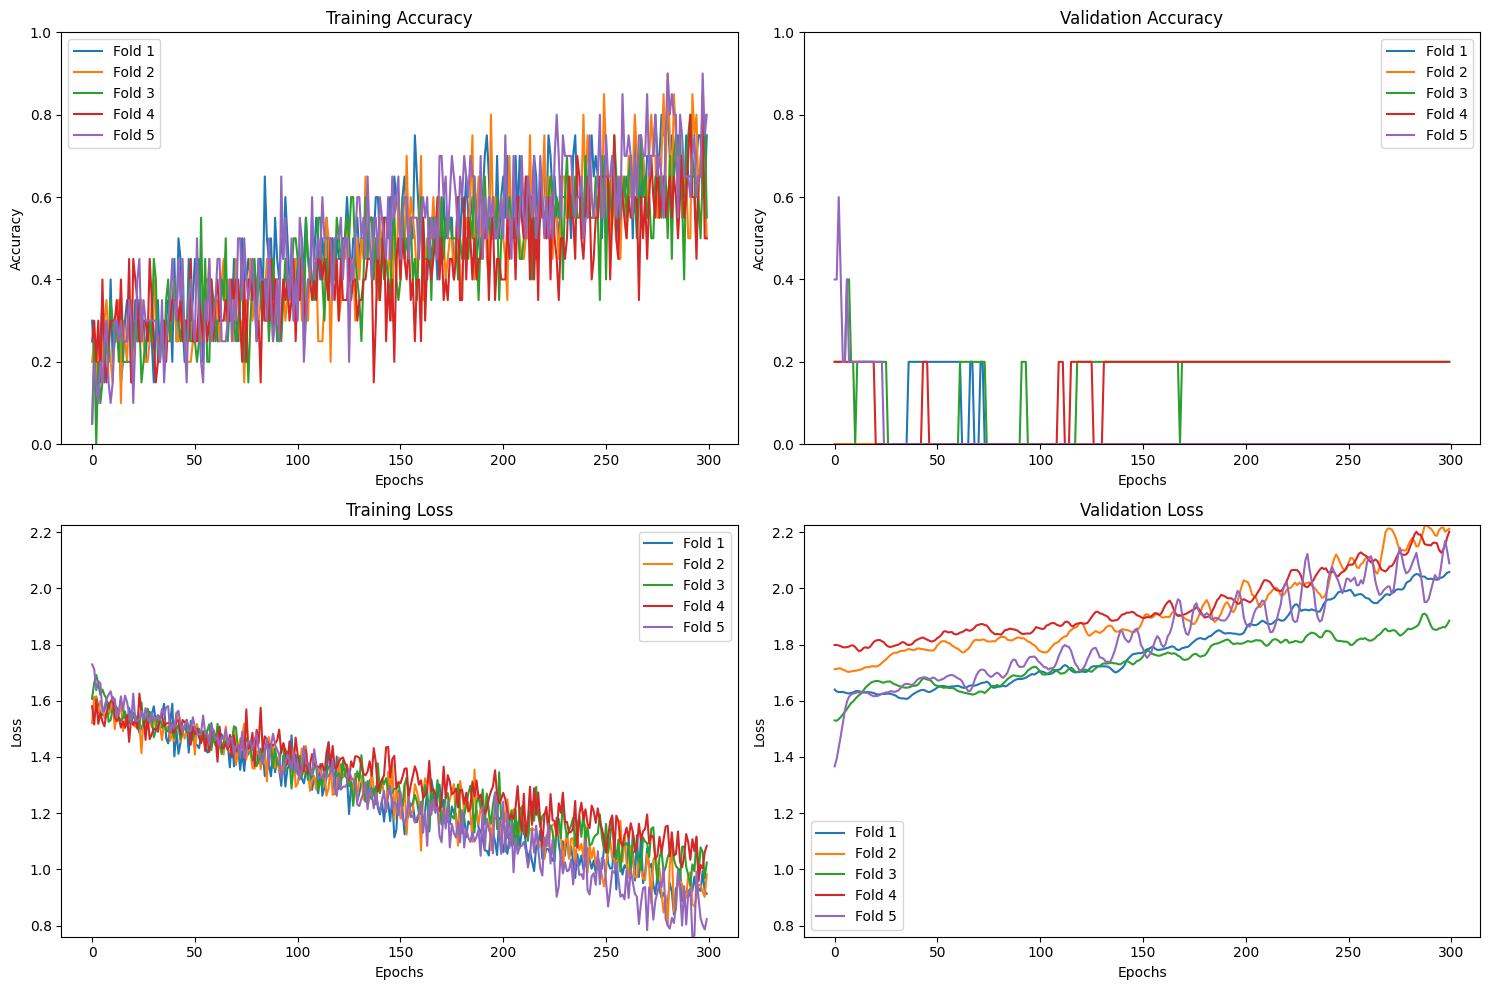

In [47]:
crossvalidate(df_second_tp, model3, predictors, "class_pond", kf)

#### Modeling in third timepoint

In [48]:
df_third_tp = df[df["timepoint"]==2]


In [49]:
model3_2 = keras.Sequential()
model3_2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3_2.add(keras.layers.Dropout(rate=0.25))
model3_2.add(keras.layers.Dense(64, activation ='relu'))
model3_2.add(keras.layers.Dropout(rate=0.25))
model3_2.add(keras.layers.Dense(16, activation ='relu'))
model3_2.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3_2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4000 - loss: 1.9482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
predicted classes:       [0 3 0 4 3]
true validation classes: [0 0 2 2 3]
mean confidence score: 4.8379, sd confidence score: 6.7771
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 2.4241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [3 2 3 0 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 1.7803, sd confidence score: 0.8167
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2000 - loss: 1.7720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted classes:       [4 2 4 3 2]
true validation classes: [0 0 2 3 4]
mean confidence score: 1.6428, sd confidence score: 1.5423
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 2.5146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [3 0 0 0 2]
true v

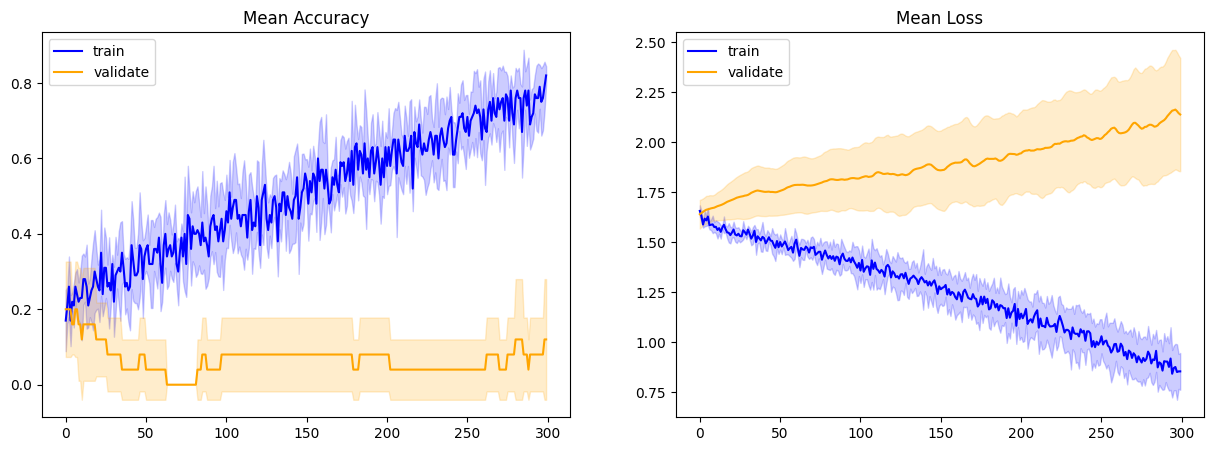

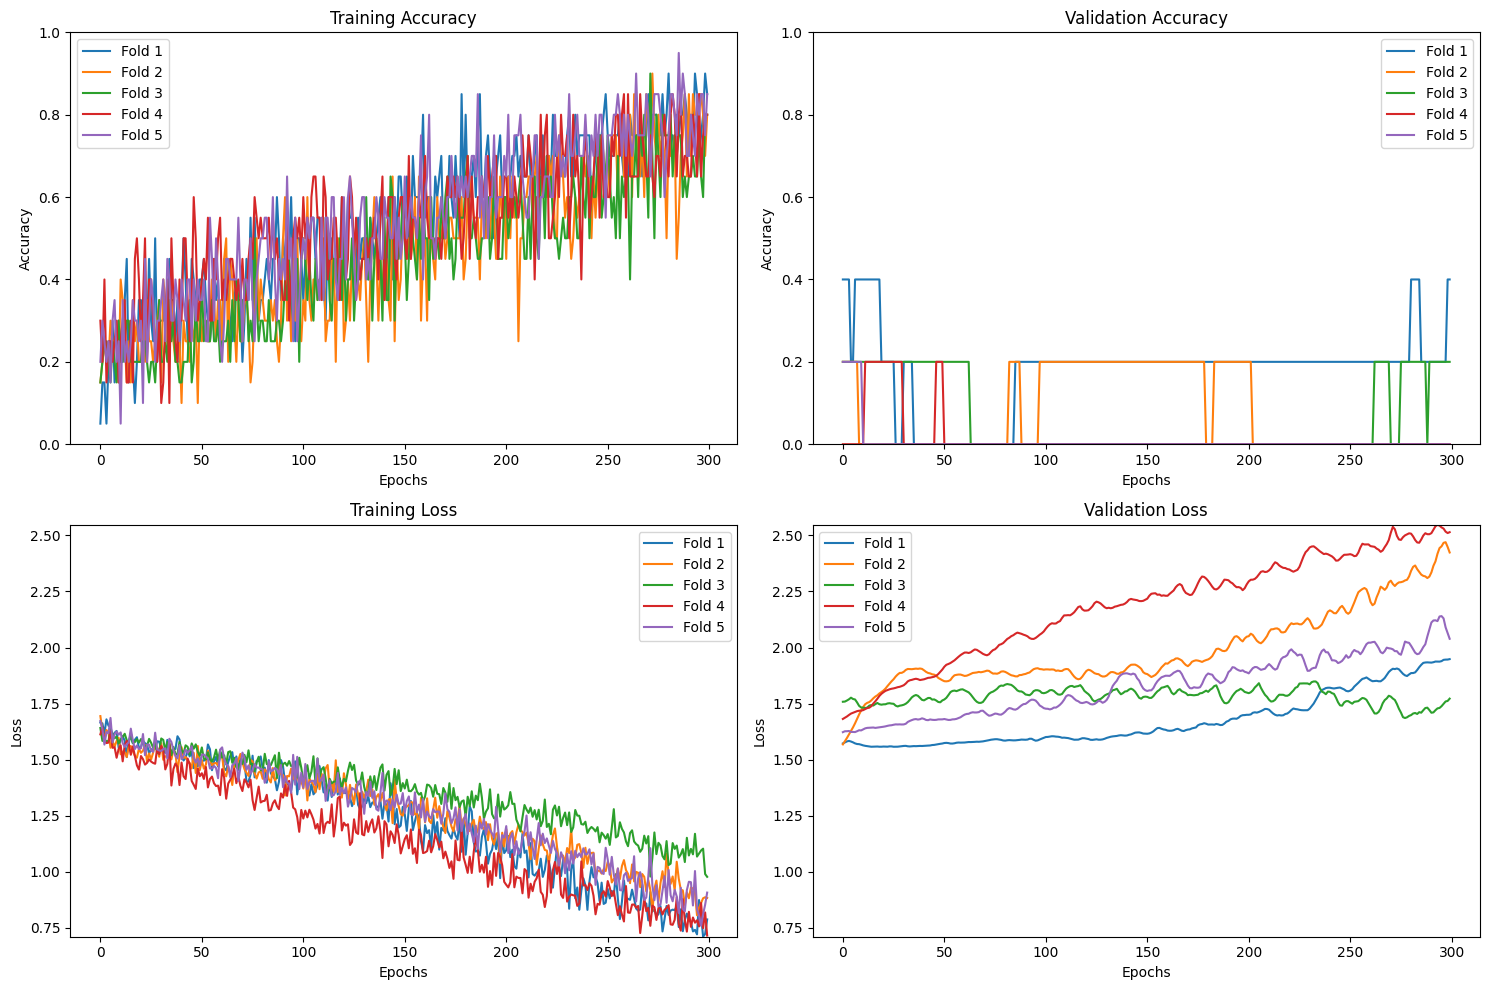

In [50]:
crossvalidate(df_third_tp, model3_2, predictors, "class_pond", kf)

Results for modeling ponds in different setups
We would expect best results in second timepoint as it is probably the timepoint that the differenecs done by supplementation can be seen the most. The case howerer is that for all the timepoints results are bad, main reson once again will be low number of samples (25 per timepoint). Thre learning curves show evel less learning and results are worse than for bacteria dataset. Probable cause for that is that KEGG paths exist in various bacteria so although its lower level biounit it is less informative in this case.

### Modeling for Experimental setup and timepoint

In [51]:
df["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df["class_timepointXpond"])
df["class_timepointXpond_encoded"] = df["class_timepointXpond_encoded"].astype(int)

In [52]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(15, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 15
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.0667 - loss: 3.3128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
predicted classes:       [14 13 13  5  5  9  1  3 14  5  7  7  2 14 14]
true validation classes: [10 11 11  6  6  6 12  7 12  8  3  8  4  9 14]
mean confidence score: 14.1262, sd confidence score: 19.7851
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 4.0651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [ 2  7  2  2  2 10 12  2  2  7  2  7  2  2  7]
true validation classes: [ 0  5  0  1  1 12 13  3  3  8  3  9  4  4  9]
mean confidence score: 16.8654, sd confidence score: 19.5504
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 2.7247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted classes:       [ 0  6  9 13  9 10  5  6 10 10  9  3  5  0 12]
true validation classes: [ 5  5  6 11  7 12  7 12  8 13  8  4 14  9 14]
mean confidence sco

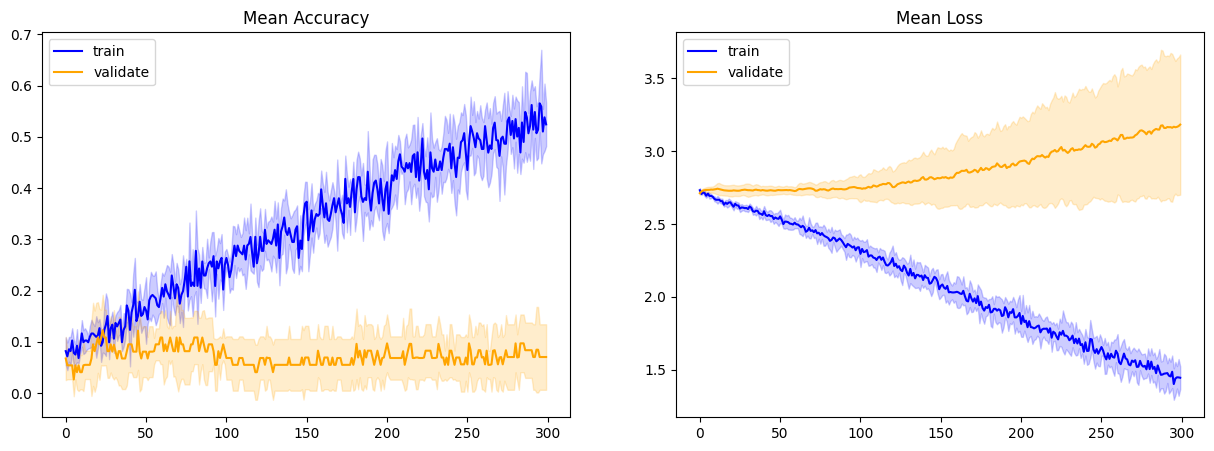

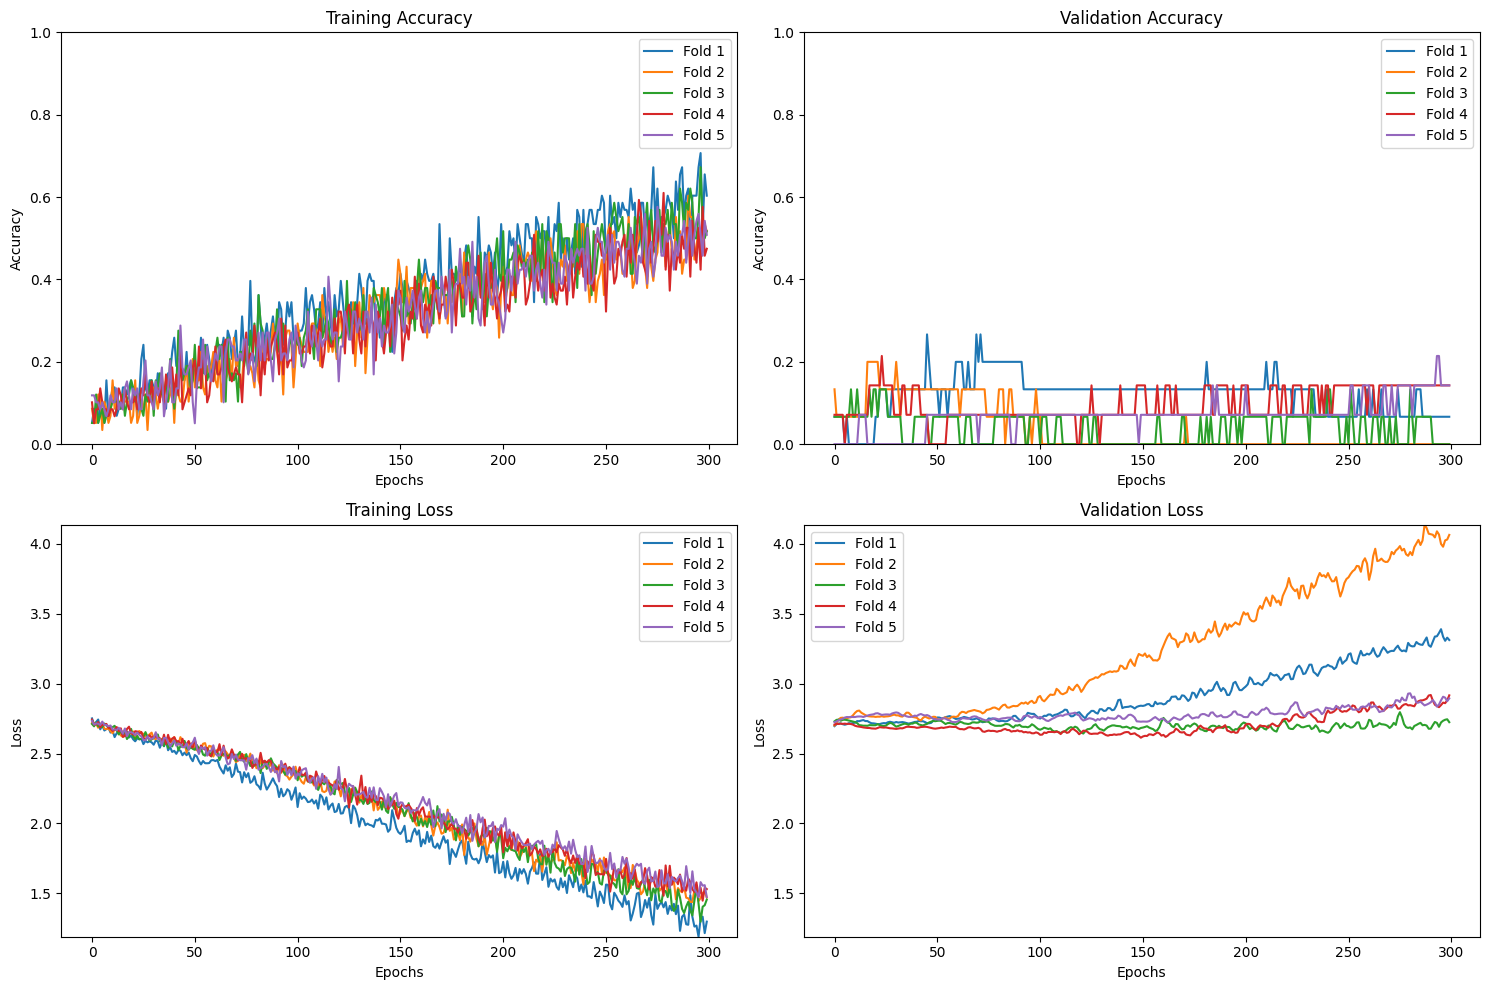

In [53]:
crossvalidate(df, model4, predictors, "class_timepointXpond_encoded", kf)

Issue here is that we didntimprove class to samples ratio so and we have even more complicated dependencies that'd require more complex model that we cannot really build with this dataset.

# Changing classes
We will now perfom same thing that helped for Gut classification but unfortunetely didnt improve for sediment at all, which is to redefine classes based on enviromental supplementation.  

In [54]:
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}
df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes3))

## modeling ponds for all timepoints

In [55]:
model5 = keras.Sequential()
model5.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
#model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(64, activation ='relu'))
#model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(16, activation ='relu'))
model5.add(keras.layers.Dense(3, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model5.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2000 - loss: 3.0318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
predicted classes:       [1 2 2 0 0 2 2 1 2 0 1 1 2 1 2]
true validation classes: [0 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
mean confidence score: 2887.4885, sd confidence score: 7252.4086
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2667 - loss: 3.9350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted classes:       [1 1 1 1 1 0 2 1 1 1 1 1 2 1 1]
true validation classes: [0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
mean confidence score: 287.9841, sd confidence score: 761.9286
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3333 - loss: 2.2224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [1 2 1 1 2 2 1 2 1 0 2 2 1 1 1]
true validation classes: [0 0 1 1 1 1 1 1 2 2 2 2 2 2 2]
mean confidence score: 14.0325, sd confidence score: 17.3714
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

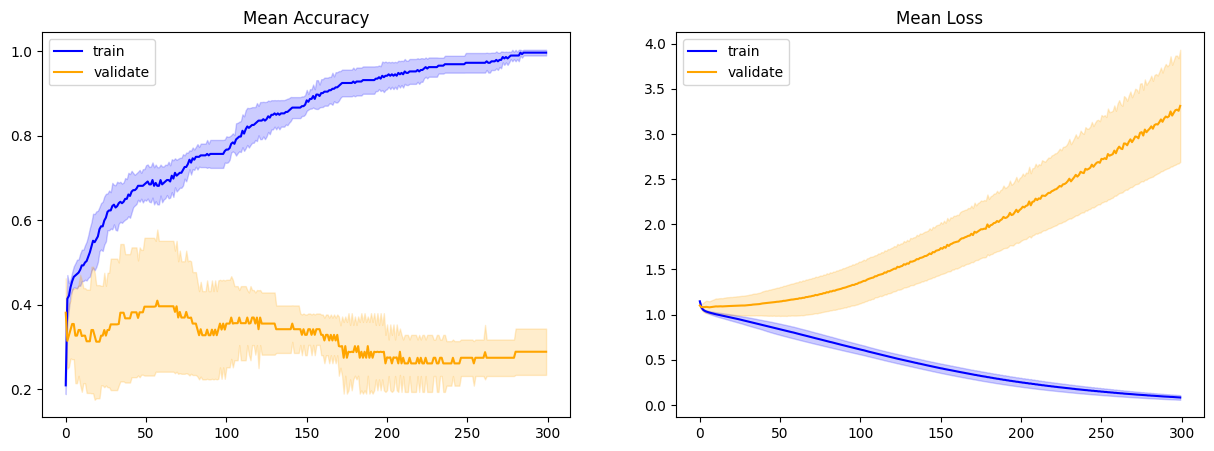

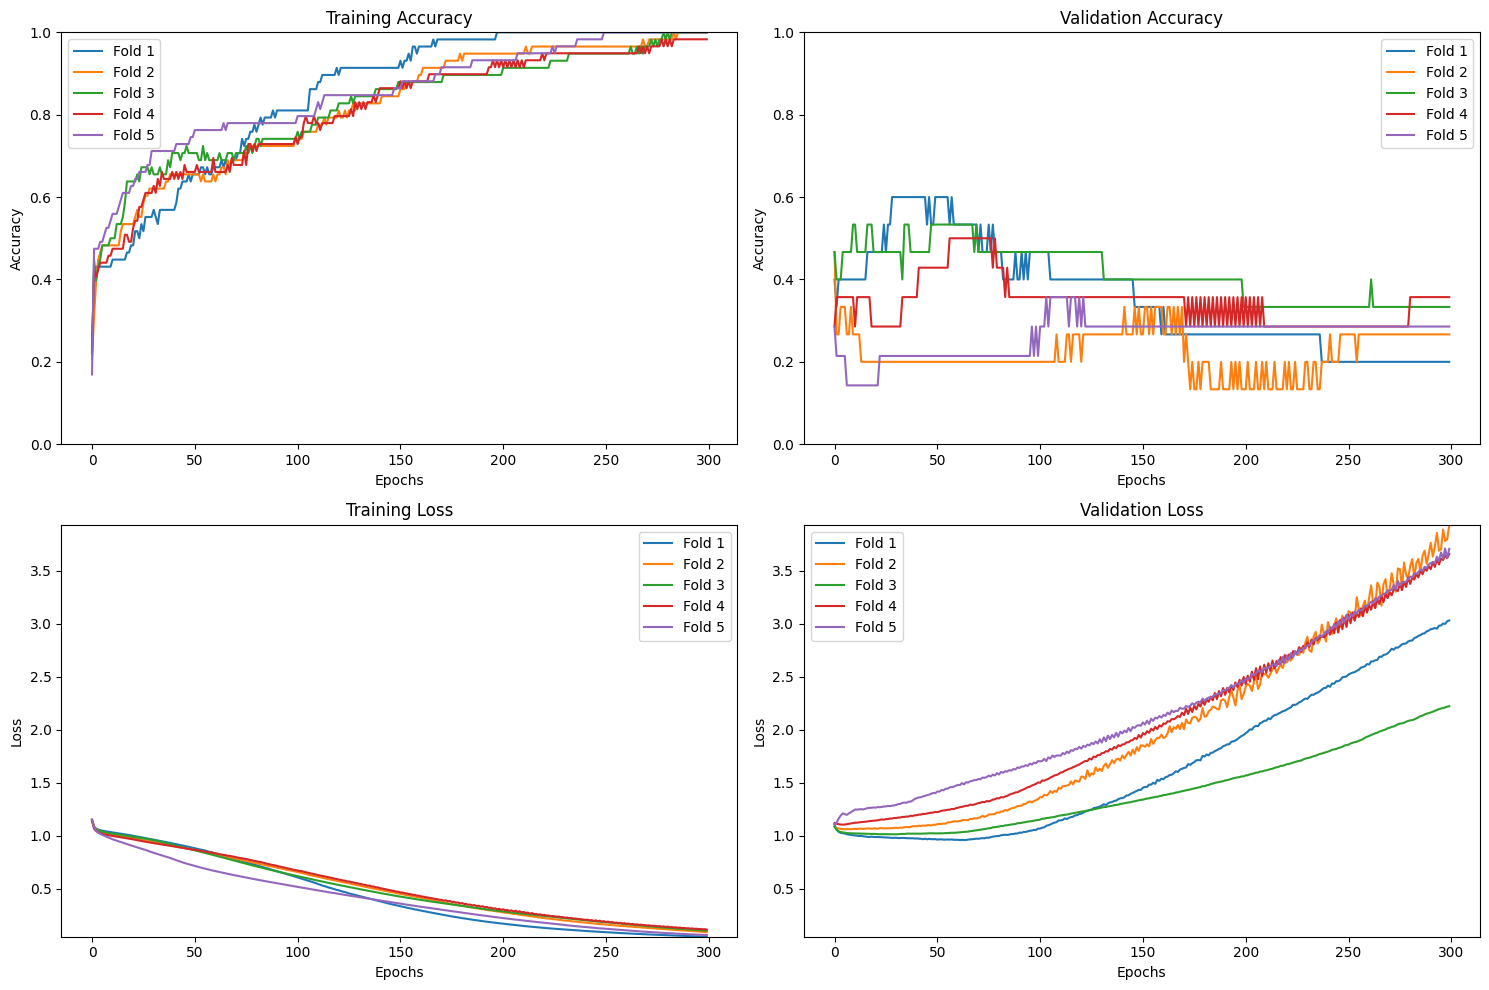

In [56]:
crossvalidate(df, model5, predictors, "class_pond", kf)

## Modeling ponds for different timepoints

### First timepoint 

Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4000 - loss: 3.1322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [1 1 2 0 0]
true validation classes: [1 1 1 2 2]
mean confidence score: 144.0656, sd confidence score: 283.6741
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2000 - loss: 2.6804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [1 2 2 2 1]
true validation classes: [0 1 1 2 2]
mean confidence score: 66.5131, sd confidence score: 105.0063
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2000 - loss: 1.9437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [2 1 1 1 1]
true validation classes: [0 1 2 2 2]
mean confidence score: 9.2379, sd confidence score: 12.291
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 2.6573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [2 1 2 2]
true valid

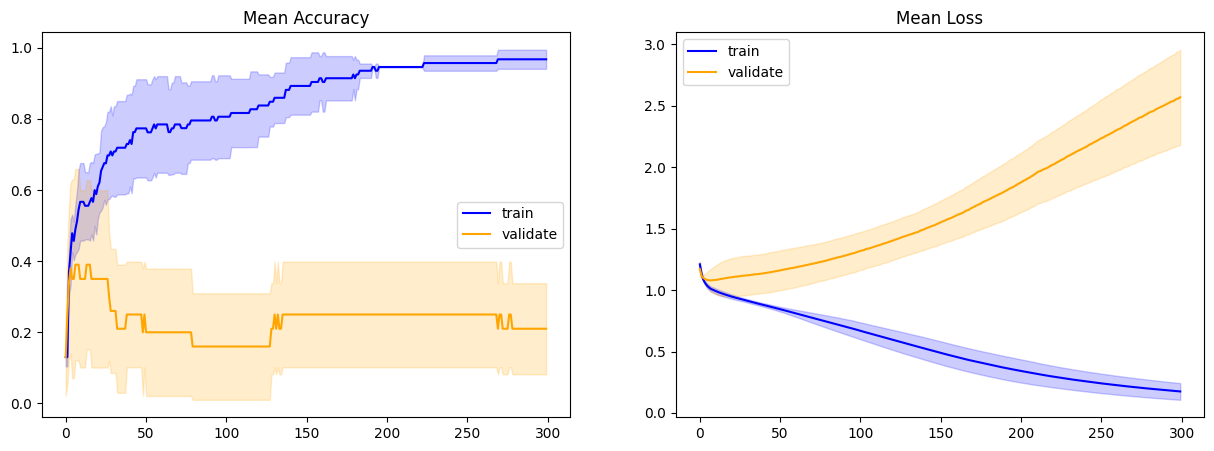

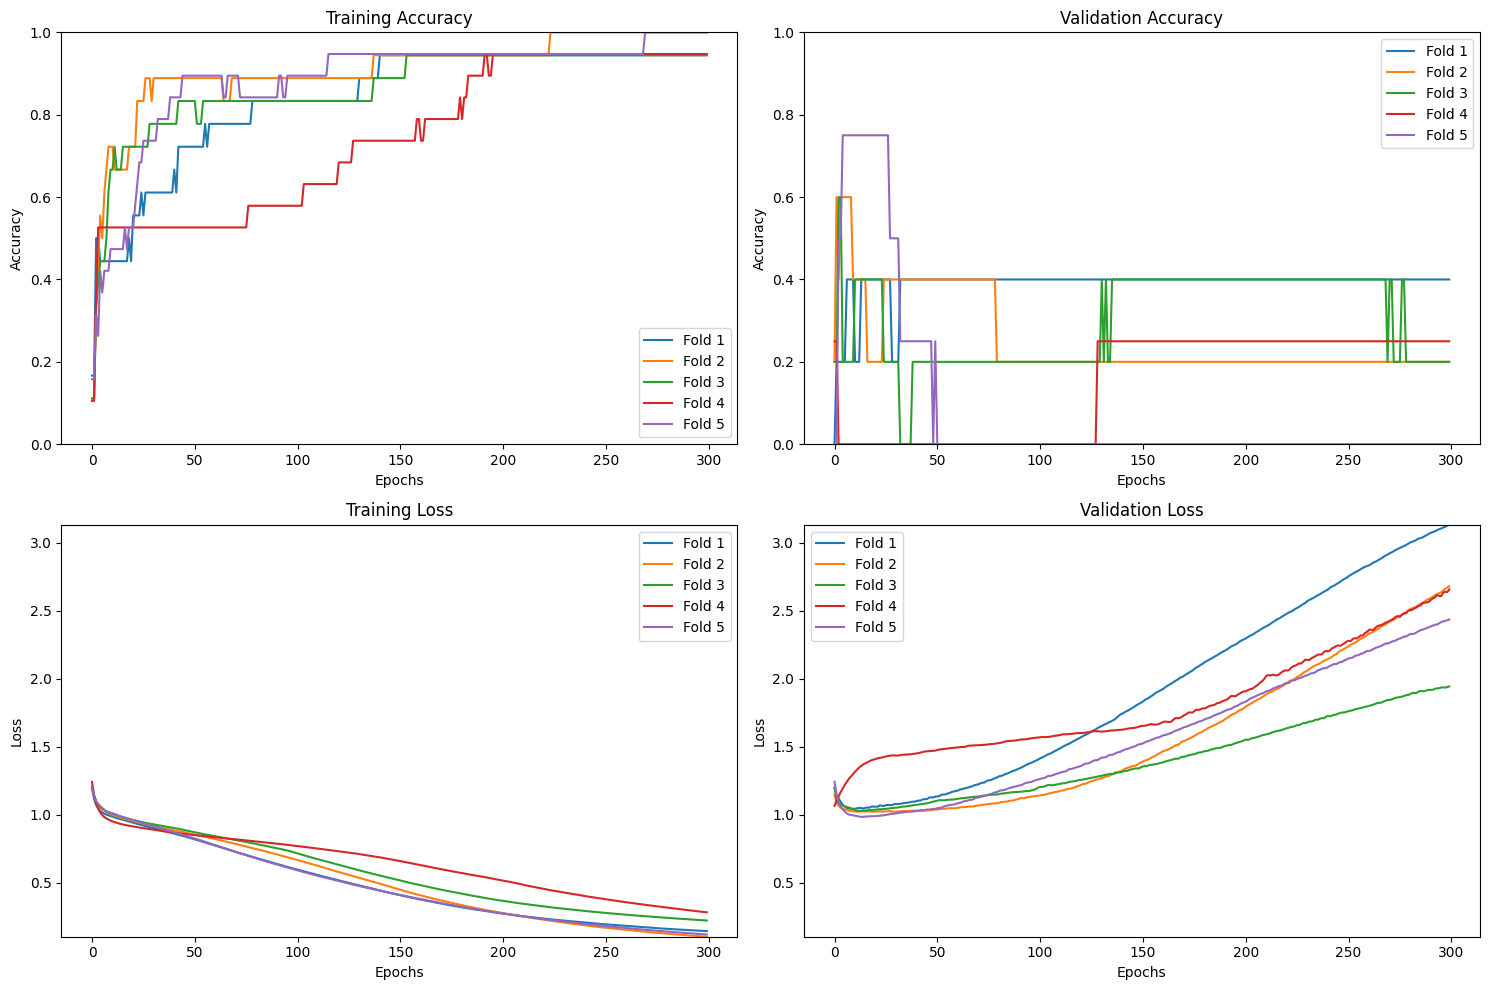

In [57]:
df_first_tp3 = df[df["timepoint"]==0]
reset_weights(model5)
crossvalidate(df_first_tp3, model5, predictors, "class_pond", kf)

### Second timepoint

Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 3.3257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [2 1 2 2 1]
true validation classes: [0 0 1 1 2]
mean confidence score: 22.4231, sd confidence score: 31.1778
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2000 - loss: 2.4691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [2 1 2 0 1]
true validation classes: [1 1 1 2 2]
mean confidence score: 27.5107, sd confidence score: 45.3996
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2000 - loss: 2.5149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted classes:       [1 2 2 1 2]
true validation classes: [0 0 1 2 2]
mean confidence score: 77.9082, sd confidence score: 85.8082
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4000 - loss: 1.3683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [0 1 0 2 1]
true 

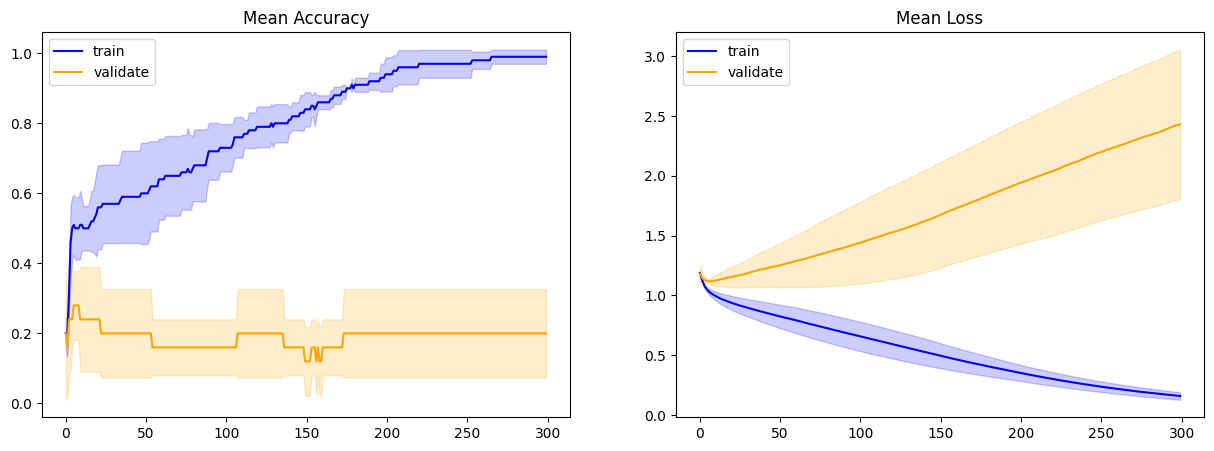

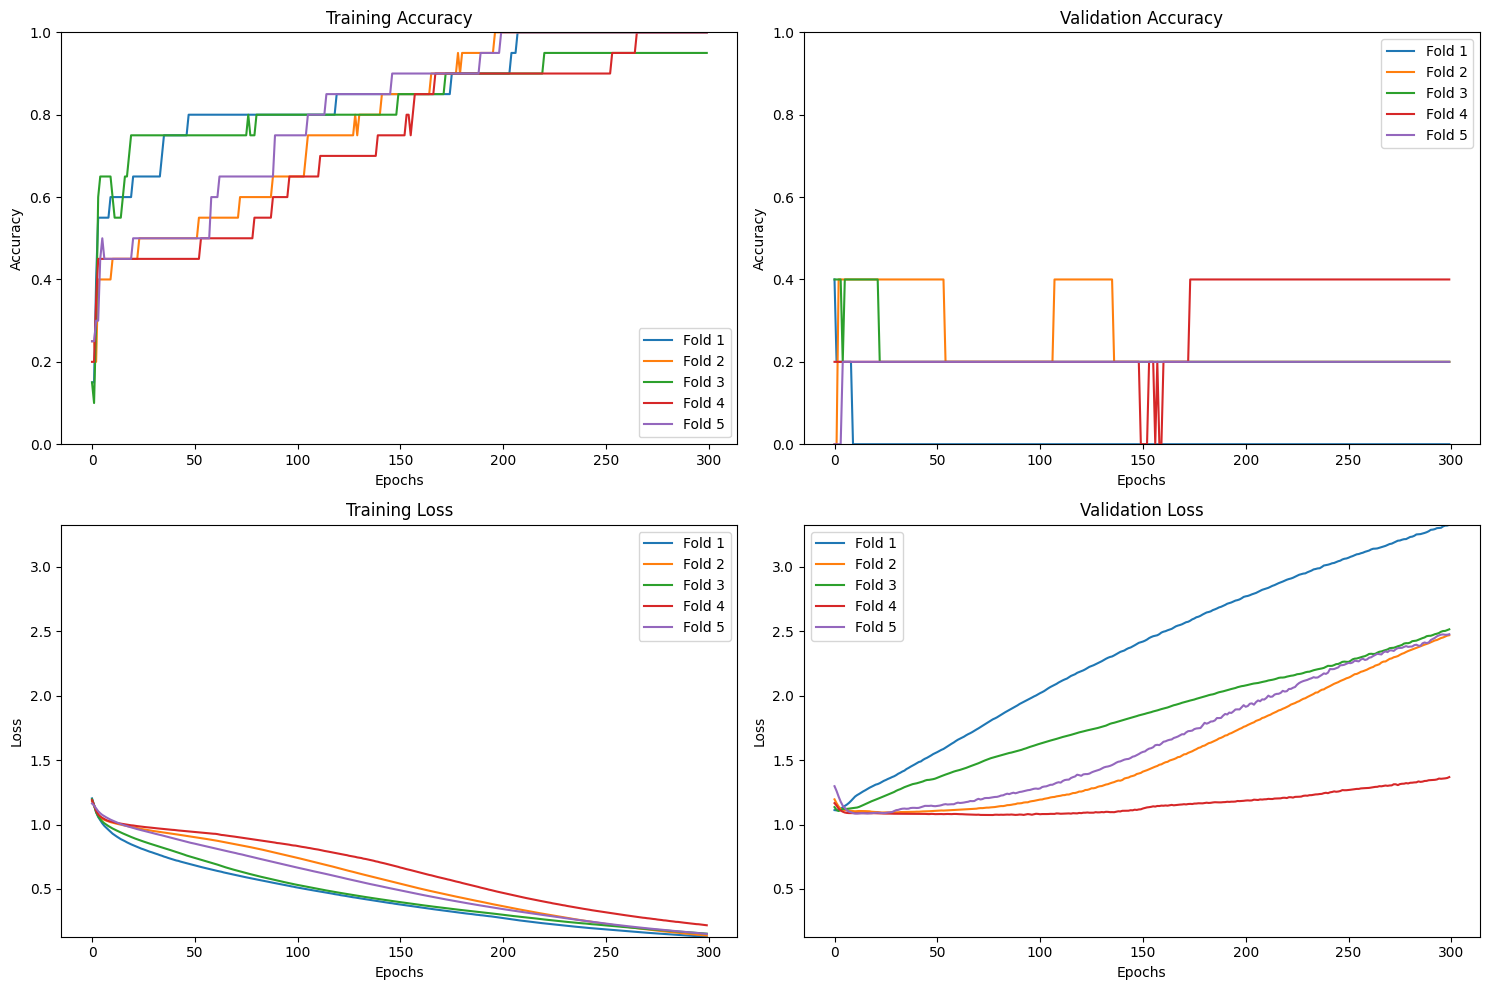

In [58]:
df_second_tp3 = df[df["timepoint"]==1]
reset_weights(model5)
crossvalidate(df_second_tp3, model5, predictors, "class_pond", kf)

### Third timepoint

Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2000 - loss: 2.4816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicted classes:       [1 2 2 2 2]
true validation classes: [0 0 1 1 2]
mean confidence score: 114.9451, sd confidence score: 226.8587
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2000 - loss: 2.8095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted classes:       [2 2 2 0 2]
true validation classes: [1 1 1 2 2]
mean confidence score: 95.4214, sd confidence score: 171.1598
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2000 - loss: 3.5305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted classes:       [1 2 2 2 1]
true validation classes: [0 0 1 2 2]
mean confidence score: 45.7797, sd confidence score: 60.5615
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0000e+00 - loss: 1.6317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [2 2 2 2 1]
tr

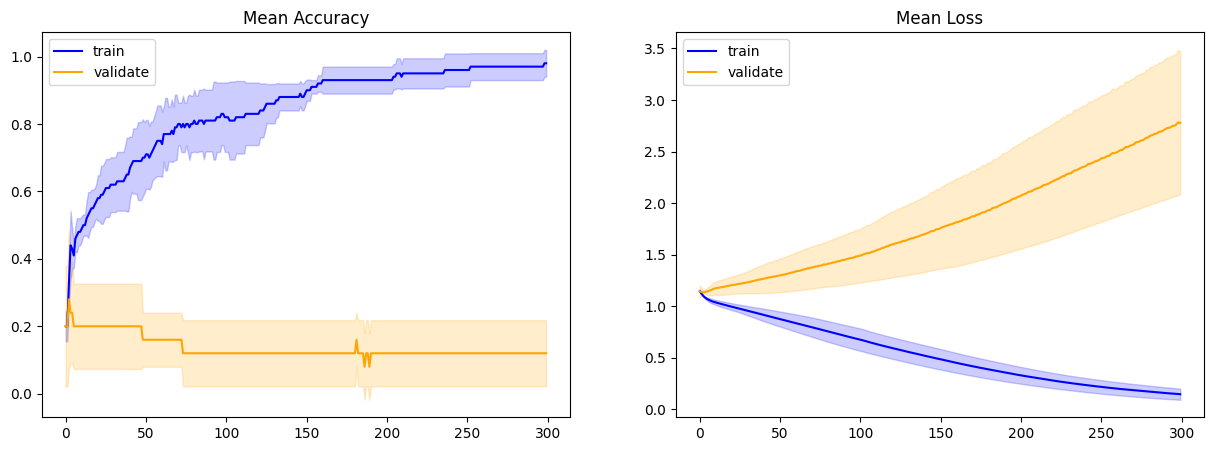

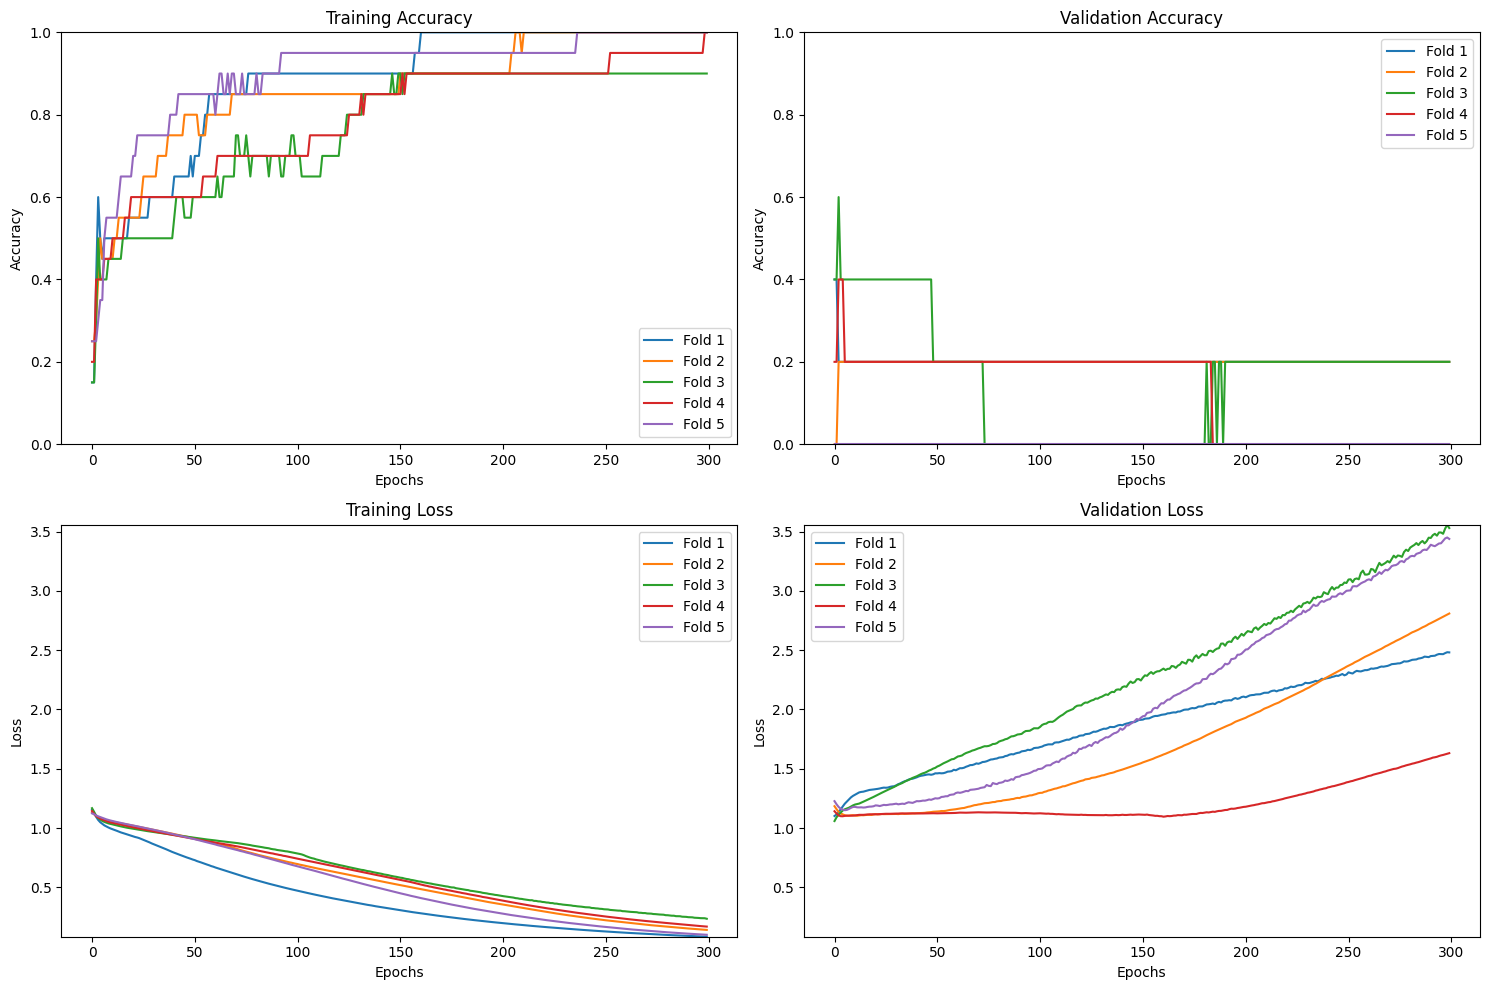

In [59]:
df_third_tp3 = df[df["timepoint"]==2]
reset_weights(model5)
crossvalidate(df_third_tp3, model5, predictors, "class_pond", kf)

We can note some general improvement of accuracy but its caused probably only because we reduced number of classes, nevertheless results are bad so we cant say that similar class redefinition helped and thus we cant say that enviromental supplementation had more impact that feed supplementation.

## Modeling ponds and timepoints at the same time 

In [60]:
df["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
le = LabelEncoder()
df["class_timepointXpond_encoded"] = le.fit_transform(df["class_timepointXpond"])
df["class_timepointXpond_encoded"] = df["class_timepointXpond_encoded"].astype(int)

In [61]:
model6 = keras.Sequential()
model6.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model6.add(keras.layers.Dropout(rate=0.25))
model6.add(keras.layers.Dense(64, activation ='relu'))
model6.add(keras.layers.Dropout(rate=0.25))
model6.add(keras.layers.Dense(16, activation ='relu'))
model6.add(keras.layers.Dense(9, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model6.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 9
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2667 - loss: 2.0168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
predicted classes:       [7 8 8 3 3 5 5 4 8 3 4 4 2 5 8]
true validation classes: [6 7 7 4 4 4 7 4 7 5 2 5 2 5 8]
mean confidence score: 14.5348, sd confidence score: 21.0261
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1333 - loss: 1.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [1 4 1 1 1 6 7 1 1 4 1 4 1 1 4]
true validation classes: [0 3 0 1 1 7 8 2 2 5 2 5 2 2 5]
mean confidence score: 24.4115, sd confidence score: 41.0758
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2667 - loss: 2.1581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [4 6 4 7 5 8 4 8 1 6 4 2 4 4 7]
true validation classes: [3 3 4 7 4 7 4 7 5 8 5 2 8 5 8]
mean confidence score: 8.3905, sd confidence score: 11.1747
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

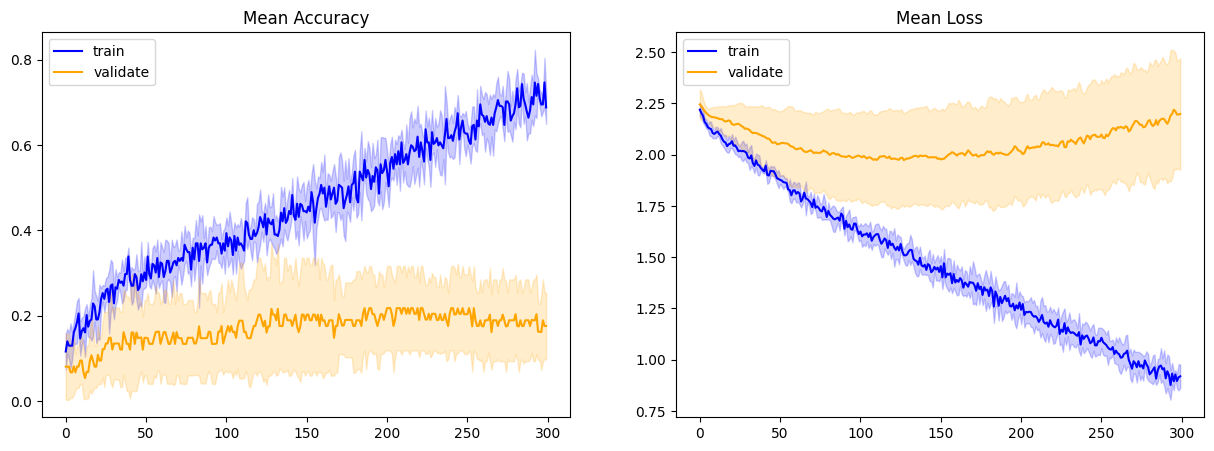

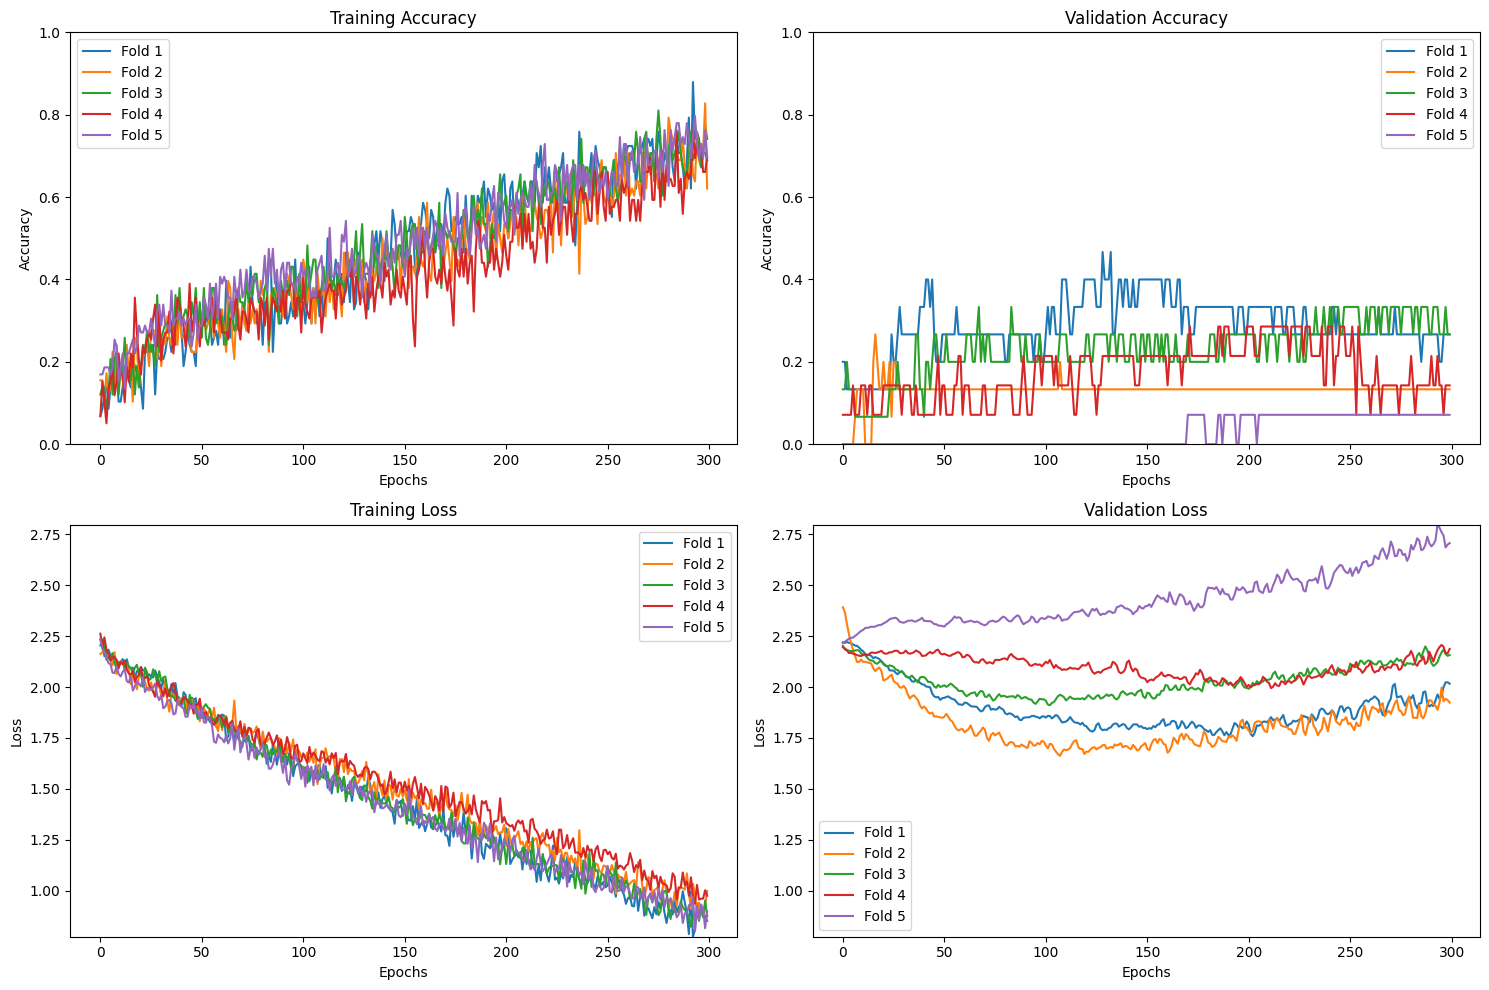

In [62]:
crossvalidate(df, model6, predictors, "class_timepointXpond_encoded", kf)

Final conclusion is that reducition of classes didnt improvement in any meaningfull way our results.

## XGBoost Comparison

### Modeling timepoints

In [63]:
X_train = train_val_df[predictors]
X_test = test_df[predictors]

In [64]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['timepoint'], feature_names=predictors.to_list())
dtest = xgb.DMatrix(X_test, label=test_df['timepoint'], feature_names=predictors.to_list())

Accuracy0.8


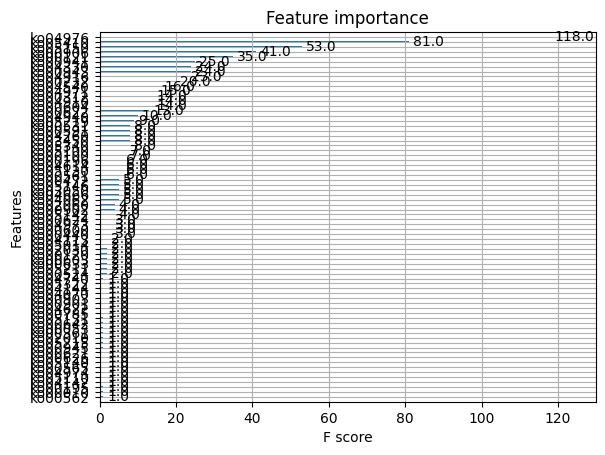

In [65]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}

x1 = xgb.train(params, dtrain, num_boost_round=100)
xgb.plot_importance(x1)
xgb_pred = x1.predict(dtest)
xgb_acc = accuracy_score(test_df['timepoint'], xgb_pred)
print(f"Accuracy{xgb_acc}")


[2 0 1 2 1 2 0 0 2 1 1 0 2 0 1]
[1. 2. 1. 0. 1. 2. 0. 0. 2. 1. 1. 0. 2. 0. 1.]
0.8


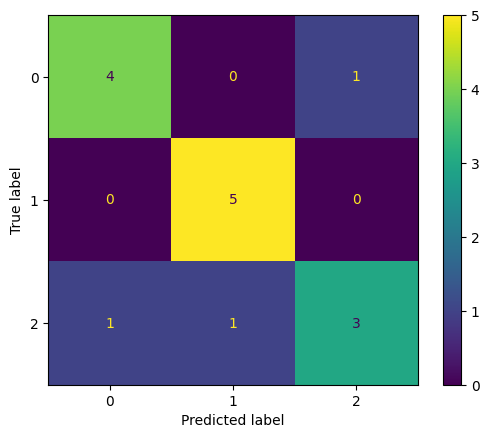

In [66]:
print(test_df['timepoint'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['timepoint'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

The accuracy as well as confusion matrix look much worse than for the bacteria dataset.

## Classifying ponds for both timepoints

In [78]:
df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

In [79]:
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=111, stratify=df['class_pond'])

In [80]:
X_train = train_val_df[predictors]
X_test = test_df[predictors]

Accuracy0.22727272727272727
true: [0 2 3 4 0 4 4 3 1 1 2 0 4 3 1 2 2 1 3 0 4 1]
predicted: [1. 0. 0. 2. 3. 0. 4. 3. 0. 3. 1. 1. 0. 2. 3. 1. 3. 1. 4. 1. 4. 1.]


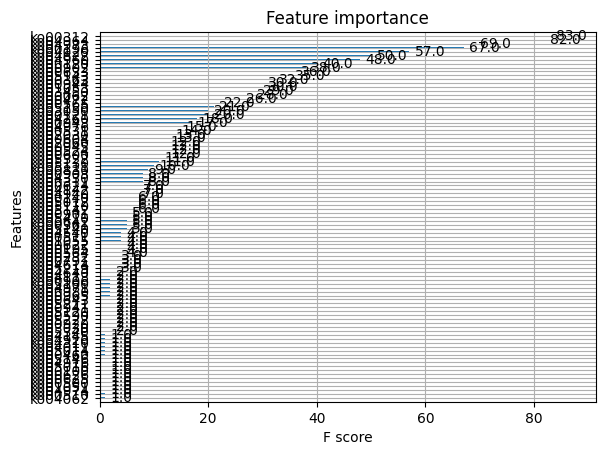

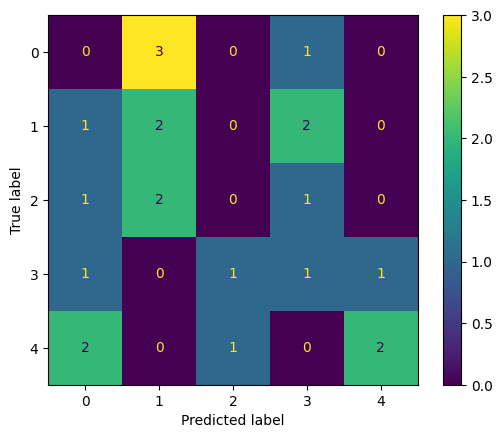

In [81]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['class_pond'].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=test_df['class_pond'].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(test_df['class_pond'].values, xgb_pred)

xgb.plot_importance(x2)

print(f"Accuracy{xgb_acc}")

print(f"true: {test_df['class_pond'].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(test_df['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

### Modeling ponds and timepoints at the same time

In [85]:
df["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
le = LabelEncoder()
df["class_timepointXpond_encoded"] = le.fit_transform(df["class_timepointXpond"])
df["class_timepointXpond_encoded"] = df["class_timepointXpond_encoded"].astype(int)

In [86]:
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=111, stratify=df['class_timepointXpond_encoded'])

Accuracy0.0
true: [ 2  8 11 14  1 13 13 12  4  5  6  0 12  9  5  7  7  4 10  2 14  3]
predicted: [ 0.  3. 13. 11.  4. 11. 11.  6.  0. 11.  9. 11.  3.  7.  1.  9.  3.  3.
  8.  3.  3.  2.]


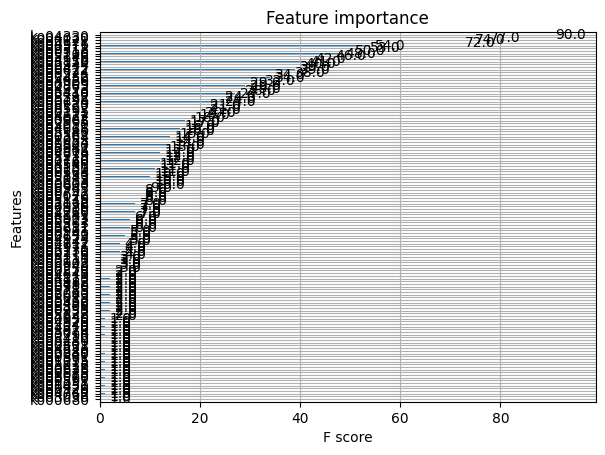

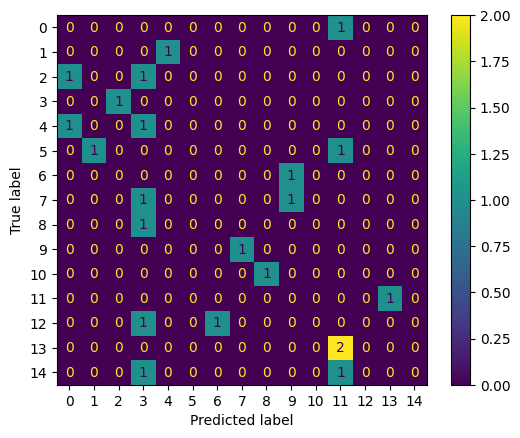

In [87]:
dtrain = xgb.DMatrix(train_val_df[predictors], label=train_val_df['class_timepointXpond_encoded'].values, feature_names=predictors.to_list())
dtest = xgb.DMatrix(test_df[predictors], label=test_df['class_timepointXpond_encoded'].values, feature_names=predictors.to_list())

params = {
    'objective': 'multi:softmax',
    'num_class': 15,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(test_df['class_timepointXpond_encoded'].values, xgb_pred)

xgb.plot_importance(x2)

print(f"Accuracy{xgb_acc}")

print(f"true: {test_df['class_timepointXpond_encoded'].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(test_df['class_timepointXpond_encoded'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

### Modeling ponds in 1 timepoint

In [88]:
df_first_tp_train, df_first_tp_test = train_test_split(df_first_tp, test_size=0.3, random_state=111, stratify=df_first_tp['class_pond'])
df_second_tp_train, df_second_tp_test = train_test_split(df_second_tp, test_size=0.3, random_state=111, stratify=df_second_tp['class_pond'])
df_third_tp_train, df_third_tp_test = train_test_split(df_third_tp, test_size=0.3, random_state=111, stratify=df_third_tp['class_pond'])
dtrain1tp = xgb.DMatrix(df_first_tp_train[predictors], label=df_first_tp_train['class_pond'].values, feature_names=predictors.to_list())
dtrain2tp = xgb.DMatrix(df_second_tp_train[predictors], label=df_second_tp_train['class_pond'].values, feature_names=predictors.to_list())
dtrain3tp = xgb.DMatrix(df_third_tp_train[predictors], label=df_third_tp_train['class_pond'].values, feature_names=predictors.to_list())
dtest1tp = xgb.DMatrix(df_first_tp_test[predictors], label=df_first_tp_test['class_pond'].values, feature_names=predictors.to_list())
dtest2tp = xgb.DMatrix(df_second_tp_test[predictors], label=df_second_tp_test['class_pond'].values, feature_names=predictors.to_list())
dtest3tp = xgb.DMatrix(df_third_tp_test[predictors], label=df_third_tp_test['class_pond'].values, feature_names=predictors.to_list())

params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}


Accuracy0.14285714285714285


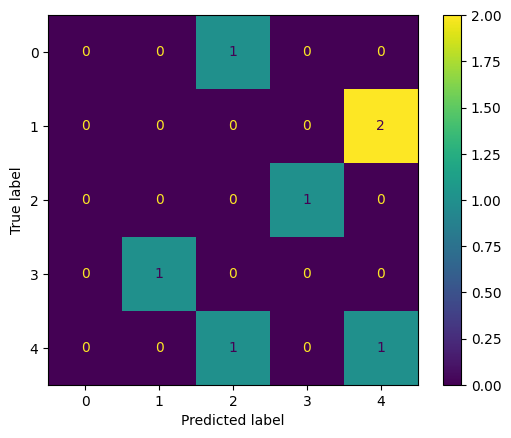

In [89]:
# first timepoint
x3 = xgb.train(params, dtrain1tp, num_boost_round=100)
xgb_pred = x3.predict(dtest1tp)
xgb_acc = accuracy_score(df_first_tp_test['class_pond'].values, xgb_pred)
print(f"Accuracy{xgb_acc}")
cm = confusion_matrix(df_first_tp_test['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

Accuracy0.0


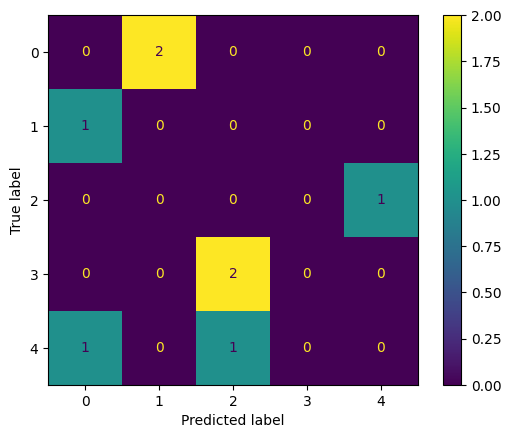

In [90]:
# second timepoint
x3 = xgb.train(params, dtrain2tp, num_boost_round=100)
xgb_pred = x3.predict(dtest2tp)
xgb_acc = accuracy_score(df_second_tp_test['class_pond'].values, xgb_pred)
print(f"Accuracy{xgb_acc}")
cm = confusion_matrix(df_second_tp_test['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

Accuracy0.0


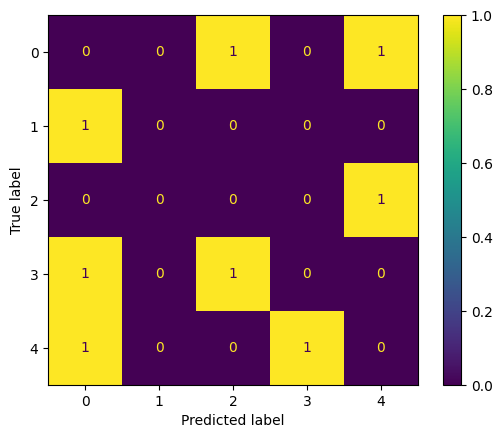

In [91]:
# third timepoint
x3 = xgb.train(params, dtrain3tp, num_boost_round=100)
xgb_pred = x3.predict(dtest3tp)
xgb_acc = accuracy_score(df_third_tp_test['class_pond'].values, xgb_pred)
print(f"Accuracy{xgb_acc}")
cm = confusion_matrix(df_third_tp_test['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()


We can say that overall results from XGBoost matched those from neural networks without any method standing out particuraly. 